# ETL
En esta notebook transformaremos nuestros archivos .csv, provistos por la iniciativa Open Data de la Ciudad de Buenos Aires. Los archivos están desordenados, en distintos formatos y separados por mes. Mediante una serie de transformaciones, convertiremos y uniremos todos estos datos en un dataset para cada estudio, según el objetivo y la información que se puede extraer.

## Setup de librerías
El siguiente bloque debe ejecutarse cada vez al inicio de una sesión de computación.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from scipy.stats import norm
import os
import glob
import pandas as pd
import requests
from io import StringIO
from bs4 import BeautifulSoup
import warnings
from scipy import stats
import gc

## Obtención de archivos
Los archivos .csv están en: https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-de-peaje-ausa. Sin embargo, los hipervínculos provistos ofrecen archivos de formatos distintos para cada año, incluidos formatos .csv, .xlsx y .zip. Para normalizar estas diferencias, utilizaremos un servidor FTP propiedad del grupo.

In [2]:
# Headers necesarios para acceder a los archivos
headers = {'User-Agent': 'Mozilla/5.0'}
ftp = 'https://libryco.com/cdd/'

In [3]:
# Función para convertir en un dataframe el archivo de un año enviado por param
def get_dataframe(year):
  # Acceder al archivo ftp
  url = ftp + f"flujo-vehicular-{year}.csv"
  response = requests.get(url, headers=headers)

  # Chequear si la respuesta fue exitosa
  if response.status_code == 200:
      # Cargar csv y devolverlo
      data = pd.read_csv(StringIO(response.text), low_memory=False)
      print(f"Archivo del año {year} cargado exitosamente.")
      return data
  else:
      print(f"Error buscando archivo del año {year}): {response.status_code}")
      return None

# Definición de columnas

Para unificar los datasets, se analizan los distintos datasets de manera individual y se establecieron las siguientes columnas que se utilizarán en el dataset final:
1.   **ID Peaje (id_peaje):** Código identificador de la unidad de peaje. Tenemos un total de 12 peajes distintos, tipificados de la siguiente forma:

| id_peaje | descripcion_peaje    |
|----------|----------------------|
| AVE      | Avellaneda           |
| DEC      | Dellepiane centro |
| ALB      | Alberdi              |
| ILL      | Illia                |
| RET      | Retiro            |
| SAL      | Salguero             |
| SAR      | Sarmiento            |


2.   **Fecha** *(fecha):* Codificado como Año-Mes-Día.
3.   **Día de la semana** *(dia):* Decidimos añadir esta columna porque nos resulta relevante para la predicción de pasos.
4.   **Hora** *(hora):* Numérica, entera. Es la hora del día en la que empezaron a registrarse los pasos.
5.   **Tipo vehículo** *(tipo_vehiculo):* El tipo de vehículo del que se han registrado los pasos.
6.   **Tipo cobro** *(tipo_cobro):* El medio de pago utilizado. Está tipificado de esta manera:

| Columna            | Descripción                                             |
|--------------------|---------------------------------------------------------|
| Efectivo           | Pago realizado en efectivo                              |
| Exento             | Exento de pago, es decir, no se requiere realizar pago   |
| Monedero virtual       | Pago realizado a través de la plataforma Mercado Pago    |
| Rec.Deuda          | Reconocimiento de deuda, registro de una deuda           |
| Tarjeta Magnetica  | Pago realizado con una tarjeta magnética de discapacidad                 |
| Tag                | Pago mediante un dispositivo electrónico (peaje automático) |
| Infraccion          | Indica que no se realizó el pago         |
| Otro                | Se utilizó otro medio de pago


7.   **Pasos** *(pasos):* Cantidad de vehículos registrados.
8.   **Sentido** *(sentido):* Dirección en la que se registraron los pasos. "Centro" para el interior de CABA, "Provincia" para el interior.


# Unificación de datasets

## Preparación año 2016

### Análisis de columnas

Se recupera el archivo de datos del 2016 y se imprimen sus columnas junto con una muestra de valores para comenzar el análisis para la unificación.

In [4]:
data_2016 = get_dataframe(2016)
print("### INFO DEL DATASET 2016 ###")
print(data_2016.info())
print()
print("############")
print()
print("### VALORES EN LAS COLUMNAS ###")
for columna in data_2016:
  print(f"\nNombre: {columna}")
  valores_unicos = data_2016[columna].unique()
  if len(valores_unicos) < 300:
    print(f"Valores: {valores_unicos}")
  else:
    print(f"Valores: {valores_unicos[:20]}...")

Archivo del año 2016 cargado exitosamente.
### INFO DEL DATASET 2016 ###
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1379443 entries, 0 to 1379442
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1379443 non-null  int64 
 1   fecha           1379443 non-null  object
 2   hora_inicio     1379443 non-null  int64 
 3   hora_fin        1379443 non-null  int64 
 4   dia             1379443 non-null  object
 5   estacion        1379443 non-null  object
 6   sentido         1379443 non-null  object
 7   tipo_vehiculo   1379443 non-null  object
 8   forma_pago      1379443 non-null  object
 9   cantidad_pasos  1379443 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 105.2+ MB
None

############

### VALORES EN LAS COLUMNAS ###

Nombre: periodo
Valores: [2016]

Nombre: fecha
Valores: ['2016-01-01' '2016-01-02' '2016-01-03' '2016-01-04' '2016-01-05'
 '2016-01-06' '2016-01-07' '2016-01

### Cambios que deben implementarse

1.   Solo trabajaremos con la hora de inicio, así que se eliminará la columna hora_fin. También se eliminará la columna periodo.
2.   Se deben cambiar los nombres de las columnas para que se ajusten a los definidos:

| Nombre original   | Nuevo nombre      |
|-------------------|-------------------|
| fecha             | fecha             |
| dia               | dia               |
| hora_inicio       | hora              |
| estacion          | id_peaje          |
| sentido           | sentido           |
| tipo_vehiculo     | tipo_vehiculo     |
| forma_pago        | tipo_cobro        |
| cantidad_pasos    | pasos             |

3.   Los días de la semana deben corregirse para que estén con la correcta codificación, es decir, que no salten problemas con los caracteres especiales. Para esto se eliminarán los tildes.
4.   La estación debe codificarse según la tabla de identificadores de peajes.
5.   La forma de pago debe codificarse según la tabla de medios de pago.





### Implementación de cambios

Comenzamos haciendo una copia del dataset para modificar y luego hacemos los cambios.

In [5]:
clean_data_2016 = data_2016.copy()

# Empezamos eliminando las columnas innecesarias
cols_to_remove = ['periodo', 'hora_fin']

# Eliminamos las columnas
clean_data_2016.drop(columns=cols_to_remove, inplace=True)
clean_data_2016.sample(5)

,fecha,hora_inicio,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
904143,2016-08-28,19,Domingo,Alberdi,Provincia,Liviano,INFRACCION,1
909731,2016-08-29,14,Lunes,Illia,Centro,Liviano,EXENTO,23
464019,2016-05-02,22,Lunes,Avellaneda,Provincia,Pesado,AUPASS,25
395387,2016-04-14,10,Jueves,Avellaneda,Centro,Liviano,NO COBRADO,4
1213898,2016-11-18,18,Viernes,Alberdi,Provincia,Liviano,NO COBRADO,2


In [6]:
# Renombramos las columnas para que tengan los nombres esperados
renamed_columns = {
    'hora_inicio': 'hora',
    'estacion': 'id_peaje',
    'tipo_vehiculo': 'tipo_vehiculo',
    'forma_pago': 'tipo_cobro',
    'cantidad_pasos': 'pasos'
}

# Renombrar las columnas
clean_data_2016.rename(columns=renamed_columns, inplace=True)
clean_data_2016.sample(5)

,fecha,hora,dia,id_peaje,sentido,tipo_vehiculo,tipo_cobro,pasos
439498,2016-04-25,19,Lunes,Retiro,Provincia,Pesado,AUPASS,10
1054171,2016-10-06,4,Jueves,Retiro,Provincia,Pesado,EFECTIVO,4
946897,2016-09-08,15,Jueves,Dellepiane Liniers,Provincia,Pesado,EFECTIVO,1
436299,2016-04-25,0,Lunes,Avellaneda,Centro,Pesado,AUPASS,4
1158629,2016-11-03,19,Jueves,Illia,Centro,Pesado,EFECTIVO,1


In [7]:
# Continuamos con la limpieza de los días
day_codification = {
    'SÃ¡bado': 'Sabado',
    'MiÃ©rcoles': 'Miercoles'
}

# Reemplazamos los valores en la columna 'dia'
clean_data_2016['dia'] = clean_data_2016['dia'].replace(day_codification)
clean_data_2016['dia'].unique()

array(['Viernes', 'Sabado', 'Domingo', 'Lunes', 'Martes', 'Miercoles',
       'Jueves'], dtype=object)

Los id_peaje se ajustan según la tabla:

| id_peaje | descripcion_peaje    |
|----------|----------------------|
| AVE      | Avellaneda           |
| DEC      | Dellepiane centro |
| ALB      | Alberdi              |
| ILL      | Illia                |
| RET      | Retiro II            |
| SAL      | Salguero             |
| SAR      | Sarmiento            |

El peaje que no se contempla en esta tabla (Dellepiane Liniers) se eliminará.

In [8]:
# Ajustamos los id_peaje
toll_codification = {
    'Alberdi': 'ALB',
    'Avellaneda': 'AVE',
    'Dellepiane Centro': 'DEC',
    'Illia': 'ILL',
    'Retiro': 'RET',
    'Salguero': 'SAL',
    'Sarmiento': 'SAR'}

clean_data_2016['id_peaje'] = clean_data_2016['id_peaje'].replace(toll_codification)
clean_data_2016.drop(clean_data_2016[~clean_data_2016['id_peaje'].isin(toll_codification.values())].index, inplace=True)
clean_data_2016['id_peaje'].unique()

array(['ALB', 'AVE', 'DEC', 'ILL', 'RET', 'SAL', 'SAR'], dtype=object)

Las formas de pago se ajustan según la tabla:

| Columna            | Descripción                                             |
|--------------------|---------------------------------------------------------|
| Efectivo           | Pago realizado en efectivo                              |
| Exento             | Exento de pago, es decir, no se requiere realizar pago   |
| Monedero virtual       | Pago realizado a través de la plataforma Mercado Pago    |
| Rec.Deuda          | Reconocimiento de deuda, registro de una deuda           |
| Tarjeta Magnetica  | Pago realizado con una tarjeta magnética                 |
| Tag                | Pago mediante un dispositivo electrónico (peaje automático) |
| Infraccion          | Indica que no se realizó el pago         |
| Otro                | Se utilizó otro medio de pago



In [9]:
# Por último, ajustamos los medios de pago
payment_codification = {
    'NO COBRADO': 'Rec.Deuda',
    'AUPASS': 'Tag',
    'EFECTIVO': 'Efectivo',
    'EXENTO': 'Exento',
    'TARJETA DISCAPACIDAD': 'Tarjeta Magnetica',
    'INFRACCION': 'Infraccion',
    'MONEDERO': 'Monedero virtual'
}

clean_data_2016['tipo_cobro'] = clean_data_2016['tipo_cobro'].replace(payment_codification)
clean_data_2016['tipo_cobro'].unique()

array(['Rec.Deuda', 'Tag', 'Efectivo', 'Exento', 'Tarjeta Magnetica',
       'Infraccion', 'Monedero virtual'], dtype=object)

In [10]:
# Observamos que el dataset quede construido correctamente
clean_data_2016.sample(10)

,fecha,hora,dia,id_peaje,sentido,tipo_vehiculo,tipo_cobro,pasos
457185,2016-04-30,1,Sabado,DEC,Centro,Pesado,Infraccion,1
120468,2016-02-02,2,Martes,AVE,Provincia,Pesado,Efectivo,19
955402,2016-09-10,22,Sabado,ILL,Centro,Pesado,Efectivo,7
633328,2016-06-16,4,Jueves,ALB,Provincia,Pesado,Exento,3
438769,2016-04-25,22,Lunes,ILL,Centro,Liviano,Infraccion,2
1110134,2016-10-21,18,Viernes,RET,Provincia,Pesado,Tag,33
165111,2016-02-14,9,Domingo,AVE,Provincia,Pesado,Tag,21
305005,2016-03-21,4,Lunes,AVE,Centro,Pesado,Efectivo,1
1181420,2016-11-09,9,Miercoles,ILL,Centro,Pesado,Efectivo,11
837574,2016-08-10,7,Miercoles,DEC,Centro,Liviano,Tarjeta Magnetica,62


## Preparación año 2017


### Análisis de columnas

Se analizan las columnas del dataset para identificar los cambios que deben hacerse para la unificación.

In [11]:
data_2017 = get_dataframe(2017)
print("### INFO DEL DATASET 2017 ###")
print(data_2017.info())
print()
print("############")
print()
print("### VALORES EN LAS COLUMNAS ###")
for columna in data_2017:
  print(f"\nNombre: {columna}")
  valores_unicos = data_2017[columna].unique()
  if len(valores_unicos) < 300:
    print(f"Valores: {valores_unicos}")
  else:
    print(f"Valores: {valores_unicos[:20]}...")

Archivo del año 2017 cargado exitosamente.
### INFO DEL DATASET 2017 ###
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372645 entries, 0 to 1372644
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1372645 non-null  int64 
 1   fecha           1372645 non-null  object
 2   hora_inicio     1372645 non-null  int64 
 3   hora_fin        1372645 non-null  int64 
 4   dia             1372645 non-null  object
 5   estacion        1372645 non-null  object
 6   sentido         1372645 non-null  object
 7   tipo_vehiculo   1372645 non-null  object
 8   forma_pago      1372645 non-null  object
 9   cantidad_pasos  1372645 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 104.7+ MB
None

############

### VALORES EN LAS COLUMNAS ###

Nombre: periodo
Valores: [2017]

Nombre: fecha
Valores: ['2017-01-01' '2017-01-02' '2017-01-03' '2017-01-04' '2017-01-05'
 '2017-01-06' '2017-01-07' '2017-01

### Cambios que deben implementarse

Se puede ver que el dataset es muy parecido al del año 2016, así que se aplicará el mismo procesamiento. La diferencia aparece en la forma de pago, en donde el "Telepase" contará como Tag y "Otros" tendrá su propia categoría.

### Implementación de cambios

In [12]:
clean_data_2017 = data_2017.copy()

# Empezamos eliminando las columnas innecesarias
cols_to_remove = ['periodo', 'hora_fin']

# Eliminamos las columnas
clean_data_2017.drop(columns=cols_to_remove, inplace=True)

# Renombramos las columnas para que tengan los nombres esperados
renamed_columns = {
    'hora_inicio': 'hora',
    'estacion': 'id_peaje',
    'tipo_vehiculo': 'tipo_vehiculo',
    'forma_pago': 'tipo_cobro',
    'cantidad_pasos': 'pasos'
}

# Renombrar las columnas
clean_data_2017.rename(columns=renamed_columns, inplace=True)

# Continuamos con la limpieza de los días
day_codification = {
    'SÃ¡bado': 'Sabado',
    'MiÃ©rcoles': 'Miercoles'
}

# Reemplazamos los valores en la columna 'dia'
clean_data_2017['dia'] = clean_data_2017['dia'].replace(day_codification)

# Ajustamos los id_peaje
toll_codification = {
    'Alberdi': 'ALB',
    'Avellaneda': 'AVE',
    'Dellepiane Centro': 'DEC',
    'Illia': 'ILL',
    'Retiro': 'RET',
    'Salguero': 'SAL',
    'Sarmiento': 'SAR'}

clean_data_2017['id_peaje'] = clean_data_2017['id_peaje'].replace(toll_codification)
clean_data_2017.drop(clean_data_2017[~clean_data_2017['id_peaje'].isin(toll_codification.values())].index, inplace=True)

# Por último, ajustamos los medios de pago, este es el único código que varía con respecto al 2016
payment_codification = {
    'NO COBRADO': 'Rec.Deuda',
    'TELEPASE': 'Tag',
    'EFECTIVO': 'Efectivo',
    'EXENTO': 'Exento',
    'TARJETA DISCAPACIDAD': 'Tarjeta Magnetica',
    'INFRACCION': 'Infraccion',
    'MONEDERO': 'Monedero virtual',
    'Otros': 'Otro',
    'CPP': 'Otro',
}

clean_data_2017['tipo_cobro'] = clean_data_2017['tipo_cobro'].replace(payment_codification)

# Imprimimos algunas filas de la tabla para ver el cambio
clean_data_2017.sample(10)

,fecha,hora,dia,id_peaje,sentido,tipo_vehiculo,tipo_cobro,pasos
712504,2017-07-09,23,Domingo,ILL,Provincia,Liviano,Efectivo,421
124711,2017-02-02,12,Jueves,SAL,Provincia,Pesado,Tag,4
829732,2017-08-09,15,Miercoles,ILL,Provincia,Pesado,Efectivo,51
721665,2017-07-12,0,Miercoles,AVE,Provincia,Pesado,Tag,22
479101,2017-05-08,0,Lunes,ILL,Centro,Pesado,Exento,2
278114,2017-03-15,16,Miercoles,ILL,Centro,Pesado,Efectivo,2
1168788,2017-11-07,14,Martes,ILL,Provincia,Pesado,Efectivo,6
1370288,2017-12-31,0,Domingo,AVE,Centro,Pesado,Tag,3
1171366,2017-11-08,14,Miercoles,DEC,Centro,Pesado,Efectivo,23
685176,2017-07-02,14,Domingo,DEC,Centro,Pesado,Tag,28


## Preparación año 2018

### Análisis de columnas

Se analizan las columnas del dataset para identificar los cambios que deben hacerse para la unificación.

In [13]:
data_2018 = get_dataframe(2018)
print("### INFO DEL DATASET 2018 ###")
print(data_2018.info())
print()
print("############")
print()
print("### VALORES EN LAS COLUMNAS ###")
for columna in data_2018:
  print(f"\nNombre: {columna}")
  valores_unicos = data_2018[columna].unique()
  if len(valores_unicos) < 300:
    print(f"Valores: {valores_unicos}")
  else:
    print(f"Valores: {valores_unicos[:20]}...")

Archivo del año 2018 cargado exitosamente.
### INFO DEL DATASET 2018 ###
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375908 entries, 0 to 1375907
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1375908 non-null  int64 
 1   fecha           1375908 non-null  object
 2   hora_inicio     1375908 non-null  int64 
 3   hora_fin        1375908 non-null  int64 
 4   dia             1375908 non-null  object
 5   estacion        1375908 non-null  object
 6   sentido         1375908 non-null  object
 7   tipo_vehiculo   1375908 non-null  object
 8   forma_pago      1375908 non-null  object
 9   cantidad_pasos  1375908 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 105.0+ MB
None

############

### VALORES EN LAS COLUMNAS ###

Nombre: periodo
Valores: [2018]

Nombre: fecha
Valores: ['2018-01-01' '2018-01-02' '2018-01-03' '2018-01-04' '2018-01-05'
 '2018-01-06' '2018-01-07' '2018-01

### Cambios que deben implementarse

Se puede ver que el dataset es muy parecido al de los años anteriores, así que se aplicará el mismo procesamiento.

### Implementación de cambios

In [14]:
clean_data_2018 = data_2018.copy()

# Empezamos eliminando las columnas innecesarias
cols_to_remove = ['periodo', 'hora_fin']

# Eliminamos las columnas
clean_data_2018.drop(columns=cols_to_remove, inplace=True)

# Renombramos las columnas para que tengan los nombres esperados
renamed_columns = {
    'hora_inicio': 'hora',
    'estacion': 'id_peaje',
    'tipo_vehiculo': 'tipo_vehiculo',
    'forma_pago': 'tipo_cobro',
    'cantidad_pasos': 'pasos'
}

# Renombrar las columnas
clean_data_2018.rename(columns=renamed_columns, inplace=True)

# Continuamos con la limpieza de los días
day_codification = {
    'SÃ¡bado': 'Sabado',
    'MiÃ©rcoles': 'Miercoles'
}

# Reemplazamos los valores en la columna 'dia'
clean_data_2018['dia'] = clean_data_2018['dia'].replace(day_codification)

# Ajustamos los id_peaje
toll_codification = {
    'Alberdi': 'ALB',
    'Avellaneda': 'AVE',
    'Dellepiane Centro': 'DEC',
    'Illia': 'ILL',
    'Retiro': 'RET',
    'Salguero': 'SAL',
    'Sarmiento': 'SAR'}

clean_data_2018['id_peaje'] = clean_data_2018['id_peaje'].replace(toll_codification)
clean_data_2018.drop(clean_data_2018[~clean_data_2018['id_peaje'].isin(toll_codification.values())].index, inplace=True)

# Por último, ajustamos los medios de pago
payment_codification = {
    'NO COBRADO': 'Rec.Deuda',
    'TELEPASE': 'Tag',
    'EFECTIVO': 'Efectivo',
    'EXENTO': 'Exento',
    'TARJETA DISCAPACIDAD': 'Tarjeta Magnetica',
    # se considera a la tarjeta de discapacidad como un tipo exento de pago
    'INFRACCION': 'Infraccion',
    'CPP': 'Otro',
}

clean_data_2018['tipo_cobro'] = clean_data_2018['tipo_cobro'].replace(payment_codification)

# Imprimimos algunas filas de la tabla para ver el cambio
clean_data_2018.sample(10)

,fecha,hora,dia,id_peaje,sentido,tipo_vehiculo,tipo_cobro,pasos
809155,2018-08-04,23,Sabado,SAL,Provincia,Liviano,Tag,25
851443,2018-08-16,7,Jueves,ALB,Centro,Liviano,Efectivo,2
168609,2018-02-14,15,Miercoles,SAL,Provincia,Pesado,Tag,4
1214695,2018-11-19,13,Lunes,ALB,Centro,Pesado,Tag,3
658623,2018-06-25,20,Lunes,AVE,Provincia,Liviano,Rec.Deuda,2835
183394,2018-02-18,3,Domingo,RET,Provincia,Pesado,Tag,1
225837,2018-03-01,10,Jueves,ILL,Provincia,Pesado,Tag,1
230282,2018-03-02,10,Viernes,RET,Provincia,Liviano,Efectivo,3
1053229,2018-10-08,17,Lunes,AVE,Provincia,Pesado,Tag,57
1004487,2018-09-24,13,Lunes,RET,Provincia,Liviano,Infraccion,2


## Preparación año 2019

### Análisis de columnas

Se analizan las columnas del dataset para identificar los cambios que deben hacerse para la unificación.

In [15]:
data_2019 = get_dataframe(2019)
print("### INFO DEL DATASET 2019 ###")
print(data_2019.info())
print()
print("############")
print()
print("### VALORES EN LAS COLUMNAS ###")
for columna in data_2019:
  print(f"\nNombre: {columna}")
  valores_unicos = data_2019[columna].unique()
  if len(valores_unicos) < 300:
    print(f"Valores: {valores_unicos}")
  else:
    print(f"Valores: {valores_unicos[:20]}...")

Archivo del año 2019 cargado exitosamente.
### INFO DEL DATASET 2019 ###
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812153 entries, 0 to 812152
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   periodo         812153 non-null  int64 
 1   fecha           812153 non-null  object
 2   hora_inicio     812153 non-null  int64 
 3   hora_fin        812153 non-null  int64 
 4   dia             812153 non-null  object
 5   estacion        812153 non-null  object
 6   sentido         812153 non-null  object
 7   tipo_vehiculo   812153 non-null  object
 8   forma_pago      812153 non-null  object
 9   cantidad_pasos  812153 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 62.0+ MB
None

############

### VALORES EN LAS COLUMNAS ###

Nombre: periodo
Valores: [2019]

Nombre: fecha
Valores: ['2019-01-01' '2019-02-01' '2019-03-01' '2019-04-01' '2019-05-01'
 '2019-06-01' '2019-07-01' '2019-08-01' '2019-09-0

### Cambios que deben implementarse

Se puede ver que el dataset es muy parecido al de los años anteriores, así que se aplicará el mismo procesamiento.

La diferencia aparece en la columna de los peajes, donde hay un peaje nuevo ("PDB"), que no está entre el listado de peajes que queremos considerar. Se eliminarán las filas que contengan este peaje.

### Implementación de cambios

In [16]:
clean_data_2019 = data_2019.copy()

# Empezamos eliminando las columnas innecesarias
cols_to_remove = ['periodo', 'hora_fin']

# Eliminamos las columnas
clean_data_2019.drop(columns=cols_to_remove, inplace=True)

# Renombramos las columnas para que tengan los nombres esperados
renamed_columns = {
    'hora_inicio': 'hora',
    'estacion': 'id_peaje',
    'forma_pago': 'tipo_cobro',
    'cantidad_pasos': 'pasos'
}

# Renombrar las columnas
clean_data_2019.rename(columns=renamed_columns, inplace=True)

# Continuamos con la limpieza de los días
day_codification = {
    'SÃ¡bado': 'Sabado',
    'MiÃ©rcoles': 'Miercoles'
}

# Reemplazamos los valores en la columna 'dia'
clean_data_2019['dia'] = clean_data_2019['dia'].replace(day_codification)

# Ajustamos los id_peaje
toll_codification = {
    'Alberti': 'ALB',
    'Avellaneda': 'AVE',
    'Dellepiane': 'DEC',
    'Illia': 'ILL',
    'Retiro': 'RET',
    'Salguero': 'SAL',
    'Sarmiento': 'SAR'}

clean_data_2019['id_peaje'] = clean_data_2019['id_peaje'].replace(toll_codification)
clean_data_2019.drop(clean_data_2019[~clean_data_2019['id_peaje'].isin(toll_codification.values())].index, inplace=True)

# Por último, ajustamos los medios de pago
payment_codification = {
    'NO COBRADO': 'Rec.Deuda',
    'TELEPASE': 'Tag',
    'EFECTIVO': 'Efectivo',
    'EXENTO': 'Exento',
    'T. DISCAPACIDAD': 'Tarjeta Magnetica',
    'INFRACCION': 'Infraccion',
    'CPP': 'Otro',
}

clean_data_2019['tipo_cobro'] = clean_data_2019['tipo_cobro'].replace(payment_codification)

# Imprimimos algunas filas de la tabla para ver el cambio
clean_data_2019.sample(10)

,fecha,hora,dia,id_peaje,sentido,tipo_vehiculo,tipo_cobro,pasos
573195,2019-09-20,13,Viernes,SAR,Provincia,Pesado,Tag,11
725452,2019-11-24,21,Domingo,ILL,Provincia,Liviano,Rec.Deuda,20
9021,2019-05-01,10,Miercoles,DEC,Provincia,Liviano,Rec.Deuda,9
430836,2019-07-20,23,Sabado,AVE,Centro,Liviano,Rec.Deuda,22
227476,2019-04-19,2,Viernes,DEC,Centro,Liviano,Rec.Deuda,2
139909,2019-08-03,20,Sabado,ILL,Provincia,Liviano,Tag,1494
178067,2019-03-26,20,Martes,AVE,Provincia,Pesado,Rec.Deuda,5
738576,2019-11-30,8,Sabado,AVE,Centro,Liviano,Exento,15
776899,2019-12-16,13,Lunes,RET,Provincia,Liviano,Efectivo,89
678834,2019-04-11,23,Jueves,DEC,Provincia,Pesado,Tag,60


## Preparación año 2020

### Análisis de columnas

Se analizan las columnas del dataset para identificar los cambios que deben hacerse para la unificación.

In [17]:
data_2020 = get_dataframe(2020)
print("### INFO DEL DATASET 2020 ###")
print(data_2020.info())
print()
print("############")
print()
print("### VALORES EN LAS COLUMNAS ###")
for columna in data_2020:
  print(f"\nNombre: {columna}")
  valores_unicos = data_2020[columna].unique()
  if len(valores_unicos) < 300:
    print(f"Valores: {valores_unicos}")
  else:
    print(f"Valores: {valores_unicos[:20]}...")

Archivo del año 2020 cargado exitosamente.
### INFO DEL DATASET 2020 ###
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2533743 entries, 0 to 2533742
Data columns (total 13 columns):
 #   Column          Dtype  
---  ------          -----  
 0   periodo         float64
 1   fecha           object 
 2   mes             object 
 3   dia             object 
 4   dia_fecha       float64
 5   hora_inicio     float64
 6   hora_fin        float64
 7   estacion        object 
 8   tipo_vehiculo   object 
 9   forma_pago      object 
 10  observacion     object 
 11  sentido         object 
 12  cantidad_pasos  float64
dtypes: float64(5), object(8)
memory usage: 251.3+ MB
None

############

### VALORES EN LAS COLUMNAS ###

Nombre: periodo
Valores: [2020.]

Nombre: fecha
Valores: ['2020-01-01 00:00:00' '2020-01-02 00:00:00' '2020-01-03 00:00:00'
 '2020-01-04 00:00:00' '2020-01-05 00:00:00' '2020-01-06 00:00:00'
 '2020-01-07 00:00:00' '2020-01-08 00:00:00' '2020-01-09 00:00:00'
 '2020-01-10 0

### Cambios que deben implementarse
A primera vista vemos que hay columnas de más, con información que si bien es útil podemos extraerla del resto de las columnas. Vamos a eliminarlas para asegurar consistencia con los otros años.

In [18]:
clean_data_2020 = data_2020.copy()

# Empezamos eliminando las columnas innecesarias
cols_to_remove = ['periodo', 'hora_fin', 'observacion', 'mes', 'dia_fecha']

# Eliminamos las columnas
clean_data_2020.drop(columns=cols_to_remove, inplace=True)

# Renombramos las columnas para que tengan los nombres esperados
renamed_columns = {
    'hora_inicio': 'hora',
    'estacion': 'id_peaje',
    'tipo_vehiculo': 'tipo_vehiculo',
    'forma_pago': 'tipo_cobro',
    'cantidad_pasos': 'pasos'
}

# Renombrar las columnas
clean_data_2020.rename(columns=renamed_columns, inplace=True)

# Continuamos con la limpieza de los días
day_codification = {
    'SÃ¡bado': 'Sabado',
    'MiÃ©rcoles': 'Miercoles'
}

# Reemplazamos los valores en la columna 'dia'
clean_data_2020['dia'] = clean_data_2020['dia'].replace(day_codification)

# Ajustamos los id_peaje
toll_codification = {
    'ALBERDI': 'ALB',
    'AVELLANEDA': 'AVE',
    'DELLEPIANE LINIERSLEPIANE CENTRO': 'DEC',
    'ILLIA': 'ILL',
    'RETIRO': 'RET',
    'SALGUERO': 'SAL',
    'SARMIENTO': 'SAR'}

clean_data_2020['id_peaje'] = clean_data_2020['id_peaje'].replace(toll_codification)
clean_data_2020.drop(clean_data_2020[~clean_data_2020['id_peaje'].isin(toll_codification.values())].index, inplace=True)

# Ajustamos los tipos de vehículo
type_codification = {
    'Auto': 'Liviano',
    'Auto con trailer': 'Liviano',
    'Moto': 'Liviano',
    'Pago doble Moto': 'Liviano',
    'Pago Doble Auto': 'Liviano',
    'Pago Doble Auto con trailer / Pesado 2 Ejes': 'Liviano',
    'Pesados 2 Ejes': 'Pesado',
    'Pesados 3 Ejes': 'Pesado',
    'Pesados 4 Ejes': 'Pesado',
    'Pesados 5 Ejes': 'Pesado',
    'Pesados 6 Ejes': 'Pesado',
    'N/D': None,
}

clean_data_2020['tipo_vehiculo'] = clean_data_2020['tipo_vehiculo'].replace(type_codification)

# Convertimos la columna 'fecha' al formato YYYY-MM-DD
clean_data_2020['fecha'] = pd.to_datetime(clean_data_2020['fecha'], format='mixed')
clean_data_2020['fecha'] = clean_data_2020['fecha'].dt.strftime('%Y-%m-%d')

# Ajustamos los strings que deberían ser enteros
clean_data_2020['hora'] = clean_data_2020['hora'].astype(int)
clean_data_2020['pasos'] = clean_data_2020['pasos'].astype(int)

# Por último, ajustamos los medios de pago
payment_codification = {
    'Tarjeta MagnÃ©tica': 'Tarjeta Magnetica',
    'ViolaciÃ³n': 'Infraccion',
    'Mercado Pago': 'Monedero virtual',
    'CPP': 'Otro',
}
clean_data_2020['tipo_cobro'] = clean_data_2020['tipo_cobro'].replace(payment_codification)

# Imprimimos algunas filas de la tabla para ver el cambio
clean_data_2020.sample(10)

,fecha,dia,hora,id_peaje,tipo_vehiculo,tipo_cobro,sentido,pasos
1249735,2020-07-23,Jueves,4,AVE,Liviano,Tag,Centro,1
2203458,2020-11-16,Lunes,13,ILL,Pesado,Rec.Deuda,Provincia,1
1600048,2020-08-16,Domingo,2,AVE,Pesado,Tag,Provincia,15
1279010,2020-07-22,Miercoles,3,AVE,Liviano,Efectivo,Centro,2
1654306,2020-09-12,Sabado,21,AVE,Liviano,Tag,Provincia,227
488791,2020-03-02,Lunes,13,ILL,Liviano,Tag,Centro,692
880372,2020-05-30,Sabado,15,AVE,Liviano,Tag,Centro,3
114837,2020-01-15,Miercoles,8,AVE,Pesado,Rec.Deuda,Provincia,2
1354694,2020-07-27,Lunes,16,RET,Pesado,Tag,Provincia,1
39226,2020-01-06,Lunes,19,AVE,Liviano,Efectivo,Provincia,2


## Preparación año 2021

### Análisis de columnas

Se analizan las columnas del dataset para identificar los cambios que deben hacerse para la unificación.

In [19]:
data_2021 = get_dataframe(2021)
print("### INFO DEL DATASET 2021 ###")
print(data_2021.info())
print()
print("############")
print()
print("### VALORES EN LAS COLUMNAS ###")
for columna in data_2021:
  print(f"\nNombre: {columna}")
  valores_unicos = data_2021[columna].unique()
  if len(valores_unicos) < 300:
    print(f"Valores: {valores_unicos}")
  else:
    print(f"Valores: {valores_unicos[:20]}...")

Archivo del año 2021 cargado exitosamente.
### INFO DEL DATASET 2021 ###
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3029367 entries, 0 to 3029366
Data columns (total 10 columns):
 #   Column                   Dtype 
---  ------                   ----- 
 0   AÃ±o de Fecha Operativa  object
 1   Cat Cobrada              object
 2   DÃ­a de Fecha Operativa  object
 3   Hora HH                  object
 4   ID Peaje                 object
 5   Mes de Fecha Operativa   object
 6   Observacion              object
 7   Sentido                  object
 8   Tipo Cobro               object
 9   Pasos                    object
dtypes: object(10)
memory usage: 231.1+ MB
None

############

### VALORES EN LAS COLUMNAS ###

Nombre: AÃ±o de Fecha Operativa
Valores: ['2021' 'Total general']

Nombre: Cat Cobrada
Valores: ['Auto' 'Auto con trailer' 'Moto' 'N/D' 'Pago doble Moto' 'Pesados 2 Ejes'
 'Pesados 3 Ejes' 'Pesados 4 Ejes' 'Pesados 5 Ejes' 'Pesados 6 Ejes'
 'Total' 'Pago Doble Auto con trai

### Cambios necesarios



*   Hay que renombrar las columnas
*   Hay que eliminar las columnas con las que no vamos a trabajar
*   Hay que eliminar la fila con el valor "total" en todas las casillas
*   Hay que convertir en entero las columnas de la hora y de los pasos
*   Hay que unificar las fechas y agregar la columna "día de la semana"
*   Hay que asegurarse de que todos los valores categóricos estén dentro de las categorías que trabajamos



### Implementación de cambios


In [20]:
clean_data_2021 = data_2021.copy()

# Empezamos eliminando las columnas innecesarias
cols_to_remove = ['AÃ±o de Fecha Operativa', 'Observacion']

# Eliminamos las columnas
clean_data_2021.drop(columns=cols_to_remove, inplace=True)

# Renombramos las columnas para que tengan los nombres esperados
renamed_columns = {
    'Hora HH': 'hora',
    'ID Peaje': 'id_peaje',
    'Cat Cobrada': 'tipo_vehiculo',
    'Tipo Cobro': 'tipo_cobro',
    'Pasos': 'pasos',
    'Sentido': 'sentido'
}

# Renombrar las columnas
clean_data_2021.rename(columns=renamed_columns, inplace=True)

# Ajustamos los medios de pago
payment_codification = {
    'Tarjeta MagnÃ©tica': 'Tarjeta Magnetica',
    'ViolaciÃ³n': 'Infraccion',
    'CPP': 'Otro', 
    'Mercado Pago': 'Monedero virtual',
    
}

clean_data_2021['tipo_cobro'] = clean_data_2021['tipo_cobro'].replace(payment_codification)

# Ajustamos los tipos de vehículo
type_codification = {
    'Auto': 'Liviano',
    'Auto con trailer': 'Liviano',
    'Moto': 'Liviano',
    'Pago doble Moto': 'Liviano',
    'Pago Doble Auto': 'Liviano',
    'Pago Doble Auto con trailer / Pesado 2 Ejes': 'Liviano',
    'Pesados 2 Ejes': 'Pesado',
    'Pesados 3 Ejes': 'Pesado',
    'Pesados 4 Ejes': 'Pesado',
    'Pesados 5 Ejes': 'Pesado',
    'Pesados 6 Ejes': 'Pesado',
    'N/D': None,
    'nan': None
}

clean_data_2021['tipo_vehiculo'] = clean_data_2021['tipo_vehiculo'].replace(type_codification)

# Eliminamos las filas con los id_peajes que no seleccionamos
tolls = ['ALB', 'AVE', 'DEC', 'ILL', 'RET', 'SAL', 'SAR']
clean_data_2021.drop(clean_data_2021[~clean_data_2021['id_peaje'].isin(tolls)].index, inplace=True)

# Eliminamos la última fila, que contiene la palabra "total" en las celdas
# y ajustamos los strings que deberían ser enteros
clean_data_2021.drop(clean_data_2021.index[-1], inplace=True)

clean_data_2021['hora'] = clean_data_2021['hora'].astype(int)
clean_data_2021['pasos'] = clean_data_2021['pasos'].astype(int)

# Imprimimos algunas filas de la tabla para ver el cambio
clean_data_2021.sample(10)

,tipo_vehiculo,DÃ­a de Fecha Operativa,hora,id_peaje,Mes de Fecha Operativa,sentido,tipo_cobro,pasos
1358405,Liviano,10,22,RET,julio,Provincia,Tag,3
2212157,Pesado,16,3,AVE,septiembre,Provincia,Tag,1
2672701,Pesado,18,17,AVE,noviembre,Provincia,Monedero virtual,8
2817027,Liviano,18,10,AVE,diciembre,Provincia,Efectivo,836
2114565,Liviano,8,15,ALB,septiembre,Provincia,Tag,1
2824970,Liviano,21,17,AVE,diciembre,Provincia,Tag,439
1941996,Pesado,14,9,RET,septiembre,Provincia,Tag,1
1384759,Liviano,22,15,ILL,julio,Provincia,Tarjeta Magnetica,4
2589701,Liviano,27,18,ALB,noviembre,Provincia,Efectivo,65
780303,Pesado,4,13,DEC,febrero,Centro,Tag,48


In [21]:
# Unificamos las fechas en una sola columna
month = {
    'enero': '01',
    'febrero': '02',
    'marzo': '03',
    'abril': '04',
    'mayo': '05',
    'junio': '06',
    'julio': '07',
    'agosto': '08',
    'septiembre': '09',
    'octubre': '10',
    'noviembre': '11',
    'diciembre': '12'
}

clean_data_2021['Mes de Fecha Operativa'] = clean_data_2021['Mes de Fecha Operativa'].replace(month)

# Creamos la nueva columna 'fecha' en el formato YYYY-MM-DD
clean_data_2021['fecha'] = '2021-' + clean_data_2021['Mes de Fecha Operativa'] + '-' + clean_data_2021['DÃ­a de Fecha Operativa'].str.zfill(2)

# Eliminamos las columnas que ya no necesitamos
clean_data_2021.drop(columns=['DÃ­a de Fecha Operativa', 'Mes de Fecha Operativa'], inplace=True)

# Construimos la columna día a partir de la fecha
date = pd.to_datetime(clean_data_2021['fecha'], format='%Y-%m-%d')
clean_data_2021['dia'] = date.dt.day_name()

days_conversor = {
    'Monday': 'Lunes',
    'Tuesday': 'Martes',
    'Wednesday': 'Miercoles',
    'Thursday': 'Jueves',
    'Friday': 'Viernes',
    'Saturday': 'Sabado',
    'Sunday': 'Domingo'
}

# Reemplazar los nombres en inglés por español
clean_data_2021['dia'] = clean_data_2021['dia'].replace(days_conversor)

clean_data_2021.sample(10)

,tipo_vehiculo,hora,id_peaje,sentido,tipo_cobro,pasos,fecha,dia
495701,Liviano,18,DEC,Centro,Infraccion,2,2021-05-17,Lunes
2083487,Liviano,4,ILL,Provincia,Tag,61,2021-09-18,Sabado
861329,Pesado,17,AVE,Provincia,Rec.Deuda,1,2021-02-19,Viernes
757201,Liviano,12,ILL,Centro,Monedero virtual,1,2021-02-28,Domingo
1598879,Liviano,18,ALB,Centro,Tag,243,2021-08-12,Jueves
2523342,Pesado,11,AVE,Provincia,Tag,1,2021-10-30,Sabado
1354362,Liviano,3,SAR,Provincia,Infraccion,1,2021-07-09,Viernes
255281,Liviano,20,AVE,Centro,Exento,10,2021-03-15,Lunes
1735104,Pesado,17,RET,Provincia,Tag,4,2021-08-04,Miercoles
362266,Pesado,4,DEC,Centro,Rec.Deuda,1,2021-03-18,Jueves


## Preparación año 2022

### Unificación de archivos mensuales
Este año y los que le siguen tienen la particularidad de tener separados por mes los archivos .csv, de manera que hay que unificarlos primero para tener consistencia con el resto de los años.

#### Obtención de archivos
Se recupera el archivo de datos de cada mes y se guarda en un arreglo.

In [22]:
# Ya no podemos usar la función get_dataframe() porque no disponemos de un .csv singular para todo el 2022, por lo que vamos a
# diseñar un código específico para la estructura de archivos de este año.
data_2022_split = []

# Lista con nombres de archivos
file_list = []
for i in range(1, 13):
  if i < 10:
    file_list.append(f"0{i}_2022.csv")
  else:
    file_list.append(f"{i}_2022.csv")

for file in file_list:
    url = ftp + "flujo-vehicular-2022/" + file

    # Acceder al archivo ftp
    response = requests.get(url, headers=headers)

    # Chequear si la respuesta fue exitosa
    if response.status_code == 200:
        # Cargar csv y agregarlo a la lista
        data = pd.read_csv(StringIO(response.text), low_memory=False, sep=';')
        data_2022_split.append(data)
        print(f"Archivo {url} cargado")
    else:
        print(f"Error buscando archivo {url}: {response.status_code}")

Archivo https://libryco.com/cdd/flujo-vehicular-2022/01_2022.csv cargado
Archivo https://libryco.com/cdd/flujo-vehicular-2022/02_2022.csv cargado
Archivo https://libryco.com/cdd/flujo-vehicular-2022/03_2022.csv cargado
Archivo https://libryco.com/cdd/flujo-vehicular-2022/04_2022.csv cargado
Archivo https://libryco.com/cdd/flujo-vehicular-2022/05_2022.csv cargado
Archivo https://libryco.com/cdd/flujo-vehicular-2022/06_2022.csv cargado
Archivo https://libryco.com/cdd/flujo-vehicular-2022/07_2022.csv cargado
Archivo https://libryco.com/cdd/flujo-vehicular-2022/08_2022.csv cargado
Archivo https://libryco.com/cdd/flujo-vehicular-2022/09_2022.csv cargado
Archivo https://libryco.com/cdd/flujo-vehicular-2022/10_2022.csv cargado
Archivo https://libryco.com/cdd/flujo-vehicular-2022/11_2022.csv cargado
Archivo https://libryco.com/cdd/flujo-vehicular-2022/12_2022.csv cargado


#### Proceso de unificación
Una vez concatenados los archivos mensuales, se crea el nuevo archivo para su posterior transformación y unificación con el resto.

In [23]:
# Unificación de archivos del anio 2022

# Concatenación
data_2022 = pd.concat(data_2022_split, ignore_index=True)

print("### INFO DEL DATASET 2022 ###")
print(data_2022.info())
print()
print("############")
print()
print("### VALORES EN LAS COLUMNAS ###")
for columna in data_2022:
  print(f"\nNombre: {columna}")
  valores_unicos = data_2022[columna].unique()
  if len(valores_unicos) < 300:
    print(f"Valores: {valores_unicos}")
  else:
    print(f"Valores: {valores_unicos[:20]}...")

### INFO DEL DATASET 2022 ###
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3124739 entries, 0 to 3124738
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   AÃ±o de Fecha Operativ  object 
 1   Hora HH                 float64
 2   Cat Cobrada             object 
 3   ID Peaje                object 
 4   Observacion             object 
 5   Sentido                 object 
 6   Tipo Cobro              object 
 7   Pasos                   float64
dtypes: float64(2), object(6)
memory usage: 190.7+ MB
None

############

### VALORES EN LAS COLUMNAS ###

Nombre: AÃ±o de Fecha Operativ
Valores: ['2022-01-01' '2022-01-02' '2022-01-03' '2022-01-04' '2022-01-05'
 '2022-01-06' '2022-01-07' '2022-01-08' '2022-01-09' '2022-01-10'
 '2022-01-11' '2022-01-12' '2022-01-13' '2022-01-14' '2022-01-15'
 '2022-01-16' '2022-01-17' '2022-01-18' '2022-01-19' '2022-01-20']...

Nombre: Hora HH
Valores: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11

### Cambios necesarios



*   Hay que renombrar las columnas
*   Hay que eliminar las columnas con las que no vamos a trabajar
*   Hay que convertir en entero las columnas de los pasos
*   Hay que agregar una columna con el día de la semana y modificar su idioma
*   Hay que eliminar las filas que no contienen los peajes que se definieron al principio
*   Hay que asegurarse de que todos los valores categóricos estén dentro de las categorías que trabajamos

### Implementación de cambios

In [24]:
clean_data_2022 = data_2022.copy()

# Empezamos eliminando las columnas innecesarias
cols_to_remove = ['Observacion']

# Eliminamos las columnas
clean_data_2022.drop(columns=cols_to_remove, inplace=True)

# Renombramos las columnas para que tengan los nombres esperados
renamed_columns = {
    'AÃ±o de Fecha Operativ': 'fecha',
    'Hora HH': 'hora',
    'ID Peaje': 'id_peaje',
    'Cat Cobrada': 'tipo_vehiculo',
    'Tipo Cobro': 'tipo_cobro',
    'Sentido': 'sentido',
    'Pasos': 'pasos'
}
clean_data_2022.rename(columns=renamed_columns, inplace=True)

# Eliminamos las filas con los id_peajes que no seleccionamos
tolls = ['ALB', 'AVE', 'DEC', 'ILL', 'RET', 'SAL', 'SAR']
clean_data_2022.drop(clean_data_2022[~clean_data_2022['id_peaje'].isin(tolls)].index, inplace=True)


# Ajustamos los strings que deberían ser enteros
clean_data_2022['pasos'] = clean_data_2022['pasos'].astype(float).astype(int)

# Agregar una nueva columna con el día de la semana
clean_data_2022['dia'] = pd.to_datetime(clean_data_2022['fecha']).dt.day_name()

# Reemplazamos los dias de la semana de inglés a español
days_conversor = {
    'Monday': 'Lunes',
    'Tuesday': 'Martes',
    'Wednesday': 'Miercoles',
    'Thursday': 'Jueves',
    'Friday': 'Viernes',
    'Saturday': 'Sabado',
    'Sunday': 'Domingo'
}

# Reemplazar los nombres en inglés por español
clean_data_2022['dia'] = clean_data_2022['dia'].replace(days_conversor)

# Ajustamos los medios de pago
payment_codification = {
    'Tarjeta MagnÃ©tic': 'Tarjeta Magnetica',
    'ViolaciÃ³': 'Infraccion',
    'CPP': 'Otro',
    'Mercado Pago': 'Monedero virtual',
    'nan': None,
}
clean_data_2022['tipo_cobro'] = clean_data_2022['tipo_cobro'].replace(payment_codification)

# Ajustamos los sentidos
direction_codification = {
    ' Provincia ': 'Provincia',
    ' Centro ': 'Centro',
    'nan': None,
}
clean_data_2022['sentido'] = clean_data_2022['sentido'].replace(direction_codification)

# Ajustamos los tipos de vehiculos
type_of_vehicle_codification = {
    'Auto': 'Liviano',
    'Auto con trailer': 'Liviano',
    'Moto': 'Liviano',
    'Pago doble Moto': 'Liviano',
    'Pago Doble Auto': 'Liviano',
    'Pago Doble Auto con trailer / Pesado 2 Ejes': 'Liviano',
    'Pesados 2 Ejes': 'Pesado',
    'Pesados 3 Ejes': 'Pesado',
    'Pesados 4 Ejes': 'Pesado',
    'Pesados 5 Ejes': 'Pesado',
    'Pesados 6 Ejes': 'Pesado',
    'N/D': None,
}
clean_data_2022['tipo_vehiculo'] = clean_data_2022['tipo_vehiculo'].replace(type_of_vehicle_codification)

# Ajustamos los strings que deberían ser enteros
clean_data_2022['hora'] = clean_data_2022['hora'].astype(int)
clean_data_2022['pasos'] = clean_data_2022['pasos'].astype(int)

# Imprimimos algunas filas de la tabla para ver el cambio
clean_data_2022.sample(10)

,fecha,hora,tipo_vehiculo,id_peaje,sentido,tipo_cobro,pasos,dia
1512017,2022-06-30,22,Liviano,ILL,Provincia,Tarjeta Magnetica,1,Jueves
2616779,2022-11-04,7,Pesado,DEC,Centro,Monedero virtual,2,Viernes
1849925,2022-08-08,16,Liviano,ALB,Centro,Tag,20,Lunes
2041993,2022-08-31,0,Liviano,ILL,Provincia,Monedero virtual,90,Miercoles
1648239,2022-07-15,20,Liviano,AVE,Provincia,Efectivo,4260,Viernes
47013,2022-01-21,8,Liviano,DEC,Centro,Tarjeta Magnetica,7,Viernes
189784,2022-01-06,0,Pesado,AVE,Provincia,Tag,3,Jueves
370577,2022-02-09,9,Pesado,AVE,Provincia,Exento,11,Miercoles
715159,2022-03-29,10,Liviano,ALB,Provincia,Efectivo,10,Martes
1250820,2022-05-30,19,Pesado,AVE,Provincia,Rec.Deuda,1,Lunes


## Preparación año 2023

### Unificación de archivos mensuales

#### Obtención de archivos
Se recupera el archivo de datos de cada mes y se guarda en un arreglo.

In [25]:
# Ya no podemos usar la función get_dataframe() porque no disponemos de un .csv singular para todo el 2023, por lo que vamos a
# diseñar un código específico para la estructura de archivos de este año.
data_2023_split = []

# Lista con nombres de archivos
file_list = []
for i in range(1, 13):
  if i < 10:
    file_list.append(f"0{i}_2023.csv")
  else:
    file_list.append(f"{i}_2023.csv")

for file in file_list:
    url = ftp + "flujo-vehicular-2023/" + file

    # Acceder al archivo ftp
    response = requests.get(url, headers=headers)

    # Chequear si la respuesta fue exitosa
    if response.status_code == 200:
        # Cargar csv y agregarlo a la lista
        data = pd.read_csv(StringIO(response.text), low_memory=False, sep=';')
        data_2023_split.append(data)
        print(f"Archivo {url} cargado")
    else:
        print(f"Error buscando archivo {url}: {response.status_code}")

Archivo https://libryco.com/cdd/flujo-vehicular-2023/01_2023.csv cargado
Archivo https://libryco.com/cdd/flujo-vehicular-2023/02_2023.csv cargado
Archivo https://libryco.com/cdd/flujo-vehicular-2023/03_2023.csv cargado
Archivo https://libryco.com/cdd/flujo-vehicular-2023/04_2023.csv cargado
Archivo https://libryco.com/cdd/flujo-vehicular-2023/05_2023.csv cargado
Archivo https://libryco.com/cdd/flujo-vehicular-2023/06_2023.csv cargado
Archivo https://libryco.com/cdd/flujo-vehicular-2023/07_2023.csv cargado
Archivo https://libryco.com/cdd/flujo-vehicular-2023/08_2023.csv cargado
Archivo https://libryco.com/cdd/flujo-vehicular-2023/09_2023.csv cargado
Archivo https://libryco.com/cdd/flujo-vehicular-2023/10_2023.csv cargado
Archivo https://libryco.com/cdd/flujo-vehicular-2023/11_2023.csv cargado
Archivo https://libryco.com/cdd/flujo-vehicular-2023/12_2023.csv cargado


#### Proceso de unificación
Una vez concatenados los archivos mensuales, se crea el nuevo archivo para su posterior transformación y unificación con el resto.

In [26]:
# Unificación de archivos del anio 2023

# Concatenación
data_2023 = pd.concat(data_2023_split, ignore_index=True)

print("### INFO DEL DATASET 2023 ###")
print(data_2023.info())
print()
print("############")
print()
print("### VALORES EN LAS COLUMNAS ###")
for columna in data_2023:
  print(f"\nNombre: {columna}")
  valores_unicos = data_2023[columna].unique()
  if len(valores_unicos) < 300:
    print(f"Valores: {valores_unicos}")
  else:
    print(f"Valores: {valores_unicos[:20]}...")

### INFO DEL DATASET 2023 ###
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2994842 entries, 0 to 2994841
Data columns (total 8 columns):
 #   Column                                 Dtype  
---  ------                                 -----  
 0   ï»¿Mes, DÃ­a, AÃ±o de Fecha Operativa  object 
 1   Hora HH                                float64
 2   Cat Cobrada                            object 
 3   ID Peaje                               object 
 4   Observacion                            object 
 5   Sentido                                object 
 6   Tipo Cobro                             object 
 7   Pasos                                  float64
dtypes: float64(2), object(6)
memory usage: 182.8+ MB
None

############

### VALORES EN LAS COLUMNAS ###

Nombre: ï»¿Mes, DÃ­a, AÃ±o de Fecha Operativa
Valores: ['2023-01-01' '2023-01-02' '2023-01-03' '2023-01-04' '2023-01-05'
 '2023-01-06' '2023-01-07' '2023-01-08' '2023-01-09' '2023-01-10'
 '2023-01-11' '2023-01-12' '2023-01-13' '202

### Cambios necesarios


*   Hay que renombrar las columnas
*   Hay que eliminar las columnas con las que no vamos a trabajar
*   Hay que convertir en entero las columnas de la hora y de los pasos
*   Hay que agregar la columna "día de la semana"
*   Hay que asegurarse de que todos los valores categóricos estén dentro de las categorías que trabajamos

### Implementación de cambios


In [27]:
clean_data_2023 = data_2023.copy()

# Empezamos eliminando las columnas innecesarias
cols_to_remove = ['Observacion']

# Eliminamos las columnas
clean_data_2023.drop(columns=cols_to_remove, inplace=True)

# Renombramos las columnas para que tengan los nombres esperados
renamed_columns = {
    'ï»¿Mes, DÃ­a, AÃ±o de Fecha Operativa': 'fecha',
    'Hora HH': 'hora',
    'ID Peaje': 'id_peaje',
    'Cat Cobrada': 'tipo_vehiculo',
    'Tipo Cobro': 'tipo_cobro',
    'Pasos': 'pasos',
    'Sentido': 'sentido'
}

# Renombrar las columnas
clean_data_2023.rename(columns=renamed_columns, inplace=True)

# Ajustamos los medios de pago
payment_codification = {
    'Tarjeta MagnÃ©tica': 'Tarjeta Magnetica',
    'ViolaciÃ³n': 'Infraccion',
    'CPP': 'Otro',
    'Mercado Pago': 'Monedero virtual',
    'nan': None,
    'N/D': None,
    'REC DEUDA': 'Rec.Deuda',
    'DEMORAS': 'Otro'
}
clean_data_2023['tipo_cobro'] = clean_data_2023['tipo_cobro'].replace(payment_codification)

# Ajustamos los tipos de vehículo
type_codification = {
    'Auto': 'Liviano',
    'Auto con trailer': 'Liviano',
    'Moto': 'Liviano',
    'Pago doble Moto': 'Liviano',
    'Pago Doble Auto': 'Liviano',
    'Pago Doble Auto con trailer / Pesado 2 Ejes': 'Liviano',
    'Pesados 2 Ejes': 'Pesado',
    'Pesados 3 Ejes': 'Pesado',
    'Pesados 4 Ejes': 'Pesado',
    'Pesados 5 Ejes': 'Pesado',
    'Pesados 6 Ejes': 'Pesado',
    'N/D': None,
    'nan': None,
}
clean_data_2023['tipo_vehiculo'] = clean_data_2023['tipo_vehiculo'].replace(type_codification)

# Eliminamos las filas con los id_peajes que no seleccionamos
tolls = ['ALB', 'AVE', 'DEC', 'ILL', 'RET', 'SAL', 'SAR']
clean_data_2023.drop(clean_data_2023[~clean_data_2023['id_peaje'].isin(tolls)].index, inplace=True)

# Agregar una nueva columna con el día de la semana
clean_data_2023['dia'] = pd.to_datetime(clean_data_2023['fecha']).dt.day_name()

# Reemplazamos los dias de la semana de inglés a español
days_conversor = {
    'Monday': 'Lunes',
    'Tuesday': 'Martes',
    'Wednesday': 'Miercoles',
    'Thursday': 'Jueves',
    'Friday': 'Viernes',
    'Saturday': 'Sabado',
    'Sunday': 'Domingo'
}

clean_data_2023['dia'] = clean_data_2023['dia'].replace(days_conversor)

# Ajustamos los nombres de los sentidos
direction_codification = {
    ' Provincia ' : 'Provincia',
    ' Centro' : 'Centro'
}
clean_data_2023['sentido'] = clean_data_2023['sentido'].replace(direction_codification)

# Ajustamos los strings que deberían ser enteros
def convert_to_int_or_null(x):
    try:
        return int(x)
    except (ValueError, TypeError):
        return np.nan

# Aplicamos la función a la columna 'hora'
clean_data_2023['hora'] = clean_data_2023['hora'].apply(convert_to_int_or_null)

clean_data_2023['pasos'] = clean_data_2023['pasos'].astype(int)

# Imprimimos algunas filas de la tabla para ver el cambio
clean_data_2023.sample(10)

,fecha,hora,tipo_vehiculo,id_peaje,sentido,tipo_cobro,pasos,dia
2785060,2023-12-05,15.0,Liviano,AVE,Provincia,Exento,9,Martes
2407676,2023-10-21,8.0,None,SAR,Provincia,Infraccion,30,Sabado
2536617,2023-11-05,16.0,Liviano,SAR,Provincia,Infraccion,15,Domingo
2610509,2023-11-14,15.0,Pesado,AVE,Centro,Rec.Deuda,1,Martes
77500,2023-01-10,5.0,Liviano,DEC,Centro,Rec.Deuda,6,Martes
2376373,2023-10-17,13.0,Pesado,AVE,Centro,Rec.Deuda,7,Martes
1412449,2023-06-13,17.0,Liviano,ALB,Provincia,Monedero virtual,20,Martes
1691579,2023-07-20,13.0,Liviano,SAL,Provincia,Tag,31,Jueves
934542,2023-04-17,5.0,Pesado,DEC,Centro,Tag,36,Lunes
1844426,2023-08-08,14.0,Liviano,DEC,Centro,Exento,1,Martes


## Preparación año 2024
Los datos de este año se tratarán de forma especial, reservándolos para pruebas y como posible información adicional para posteriores predicciones. No se incluirán al dataset 2016 - 2023.

### Unificación de archivos mensuales

#### Obtención de archivos
Se recupera el archivo de datos de cada mes y se guarda en un arreglo.

In [28]:
# Ya no podemos usar la función get_dataframe() porque no disponemos de un .csv singular para todo el 2024, por lo que vamos a
# diseñar un código específico para la estructura de archivos de este año.
data_2024_split = []

# Lista con nombres de archivos
file_list = []
for i in range(1, 8):
  if i < 10:
    file_list.append(f"0{i}_2024.csv")
  else:
    file_list.append(f"{i}_2024.csv")

for file in file_list:
    url = ftp + "flujo-vehicular-2024/" + file

    # Acceder al archivo ftp
    response = requests.get(url, headers=headers)

    # Chequear si la respuesta fue exitosa
    if response.status_code == 200:
        # Cargar csv y agregarlo a la lista
        data = pd.read_csv(StringIO(response.text), low_memory=False, sep=';')
        data_2024_split.append(data)
        print(f"Archivo {url} cargado")
    else:
        print(f"Error buscando archivo {url}: {response.status_code}")

Archivo https://libryco.com/cdd/flujo-vehicular-2024/01_2024.csv cargado
Archivo https://libryco.com/cdd/flujo-vehicular-2024/02_2024.csv cargado
Archivo https://libryco.com/cdd/flujo-vehicular-2024/03_2024.csv cargado
Archivo https://libryco.com/cdd/flujo-vehicular-2024/04_2024.csv cargado
Archivo https://libryco.com/cdd/flujo-vehicular-2024/05_2024.csv cargado
Archivo https://libryco.com/cdd/flujo-vehicular-2024/06_2024.csv cargado
Archivo https://libryco.com/cdd/flujo-vehicular-2024/07_2024.csv cargado


#### Proceso de unificación
Una vez concatenados los archivos mensuales, se crea el nuevo archivo para su posterior transformación y unificación con el resto.

In [29]:
# Unificación de archivos del anio 2024

# Concatenación
data_2024 = pd.concat(data_2024_split, ignore_index=True)

print("### INFO DEL DATASET 2024 ###")
print(data_2024.info())
print()
print("############")
print()
print("### VALORES EN LAS COLUMNAS ###")
for columna in data_2024:
  print(f"\nNombre: {columna}")
  valores_unicos = data_2024[columna].unique()
  if len(valores_unicos) < 300:
    print(f"Valores: {valores_unicos}")
  else:
    print(f"Valores: {valores_unicos[:20]}...")

### INFO DEL DATASET 2024 ###
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1957482 entries, 0 to 1957481
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   AÃ±o de Fecha Operativ  object 
 1   Hora HH                 float64
 2   Cat Cobrada             object 
 3   ID Peaje                object 
 4   Observacion             object 
 5   Sentido                 object 
 6   Tipo Cobro              object 
 7   Pasos                   float64
dtypes: float64(2), object(6)
memory usage: 119.5+ MB
None

############

### VALORES EN LAS COLUMNAS ###

Nombre: AÃ±o de Fecha Operativ
Valores: ['2024-01-01' '2024-01-02' '2024-01-03' '2024-01-04' '2024-01-05'
 '2024-01-06' '2024-01-07' '2024-01-08' '2024-01-09' '2024-01-10'
 '2024-01-11' '2024-01-12' '2024-01-13' '2024-01-14' '2024-01-15'
 '2024-01-16' '2024-01-17' '2024-01-18' '2024-01-19' '2024-01-20'
 '2024-01-21' '2024-01-22' '2024-01-23' '2024-01-24' '2024-01-25'
 '2024-01-2

### Cambios necesarios
- Hay que renombrar las columnas
- Hay que eliminar las columnas con las que no vamos a trabajar
- Hay que convertir en entero las columnas de la hora y de los pasos
- Hay que agregar la columna "día de la semana"
- Hay que asegurarse de que todos los valores categóricos estén dentro de las categorías que trabajamos

### Implementación de los cambios

In [30]:
clean_data_2024 = data_2024.copy()

# Empezamos eliminando las columnas innecesarias
cols_to_remove = ['Observacion']

# Eliminamos las columnas
clean_data_2024.drop(columns=cols_to_remove, inplace=True)

# Renombramos las columnas para que tengan los nombres esperados
renamed_columns = {
    'AÃ±o de Fecha Operativ': 'fecha',
    'Hora HH': 'hora',
    'ID Peaje': 'id_peaje',
    'Cat Cobrada': 'tipo_vehiculo',
    'Tipo Cobro': 'tipo_cobro',
    'Pasos': 'pasos',
    'Sentido': 'sentido'
}

# Renombrar las columnas
clean_data_2024.rename(columns=renamed_columns, inplace=True)

# Ajustamos los medios de pago
payment_codification = {
    'Tarjeta MagnÃ©tica': 'Tarjeta Magnetica',
    'ViolaciÃ³': 'Infraccion',
    'CPP': 'Otro',
    'Mercado Pago': 'Monedero virtual',
    'nan': None,
    'N/D': None,
    'REC DEUDA': 'Rec.Deuda',
}
clean_data_2024['tipo_cobro'] = clean_data_2024['tipo_cobro'].replace(payment_codification)

# Ajustamos los tipos de vehículo
type_codification = {
    'Auto': 'Liviano',
    'Auto con trailer': 'Liviano',
    'Moto': 'Liviano',
    'Pago doble Moto': 'Liviano',
    'Pago Doble Auto': 'Liviano',
    'Pesados 2 Ejes': 'Pesado',
    'Pesados 3 Ejes': 'Pesado',
    'Pesados 4 Ejes': 'Pesado',
    'Pesados 5 Ejes': 'Pesado',
    'Pesados 6 Ejes': 'Pesado',
    'N/D': None,
    'nan': None,
}
clean_data_2024['tipo_vehiculo'] = clean_data_2024['tipo_vehiculo'].replace(type_codification)

# Eliminamos las filas con los id_peajes que no seleccionamos
tolls = ['ALB', 'AVE', 'DEC', 'ILL', 'RET', 'SAL', 'SAR']
clean_data_2024.drop(clean_data_2024[~clean_data_2024['id_peaje'].isin(tolls)].index, inplace=True)

# Agregar una nueva columna con el día de la semana
clean_data_2024['dia'] = pd.to_datetime(clean_data_2024['fecha']).dt.day_name()

#Reemplazamos los dias de la semana de inglés a español
days_conversor = {
    'Monday': 'Lunes',
    'Tuesday': 'Martes',
    'Wednesday': 'Miercoles',
    'Thursday': 'Jueves',
    'Friday': 'Viernes',
    'Saturday': 'Sabado',
    'Sunday': 'Domingo'
}
clean_data_2024['dia'] = clean_data_2024['dia'].replace(days_conversor)

# Ajustamos los nombres de los sentidos
direction_codification = {
    'nan' : None,
}
clean_data_2024['sentido'] = clean_data_2024['sentido'].replace(direction_codification)

# Ajustamos las fechas
direction_codification = {
    'nan' : None,
}
clean_data_2024['fecha'] = clean_data_2024['fecha'].replace(direction_codification)


# Ajustamos los strings que deberían ser enteros
clean_data_2024['hora'] = clean_data_2024['hora'].astype(int)
clean_data_2024['pasos'] = clean_data_2024['pasos'].astype(int)

# Imprimimos algunas filas de la tabla para ver el cambio
clean_data_2024.sample(10)

,fecha,hora,tipo_vehiculo,id_peaje,sentido,tipo_cobro,pasos,dia
363804,2024-02-11,12,Liviano,ALB,Provincia,Monedero virtual,21,Domingo
1779919,2024-07-14,18,Pesado,ALB,Provincia,Tag,3,Domingo
1803363,2024-07-17,17,Liviano,AVE,Centro,Rec.Deuda,38,Miercoles
1789027,2024-07-15,23,Liviano,AVE,Centro,Tag,2,Lunes
244505,2024-01-31,14,Pesado,DEC,Centro,Tag,20,Miercoles
1722307,2024-07-07,7,Liviano,AVE,Provincia,Monedero virtual,22,Domingo
697770,2024-03-18,10,Liviano,DEC,Centro,Tag,125,Lunes
28419,2024-01-04,18,Liviano,DEC,Centro,Tag,13,Jueves
749978,2024-03-24,20,Liviano,AVE,Provincia,Efectivo,20,Domingo
280686,2024-02-01,3,Pesado,AVE,Centro,Rec.Deuda,1,Jueves


##  Agrupación de los Dataset

Se realizará la agrupación de todos los dataset en uno solo ordenando las columnas según corresponda

## Caso particular: Año 2020

Antes de unificar los datos, decidimos comprobar la calidad de los datos del año 2020. En Argentina (y en todo el mundo), la pandemia de COVID19 causó que el 2020 fuera un año completamente atípico. Por ello, nos pareció significativo observar qué tan diferente es a comparación de sus años vecinos para evaluar si estos datos se incorporarían al análisis o serían descartados. 

Se generó una gráfica para comprobarlo.

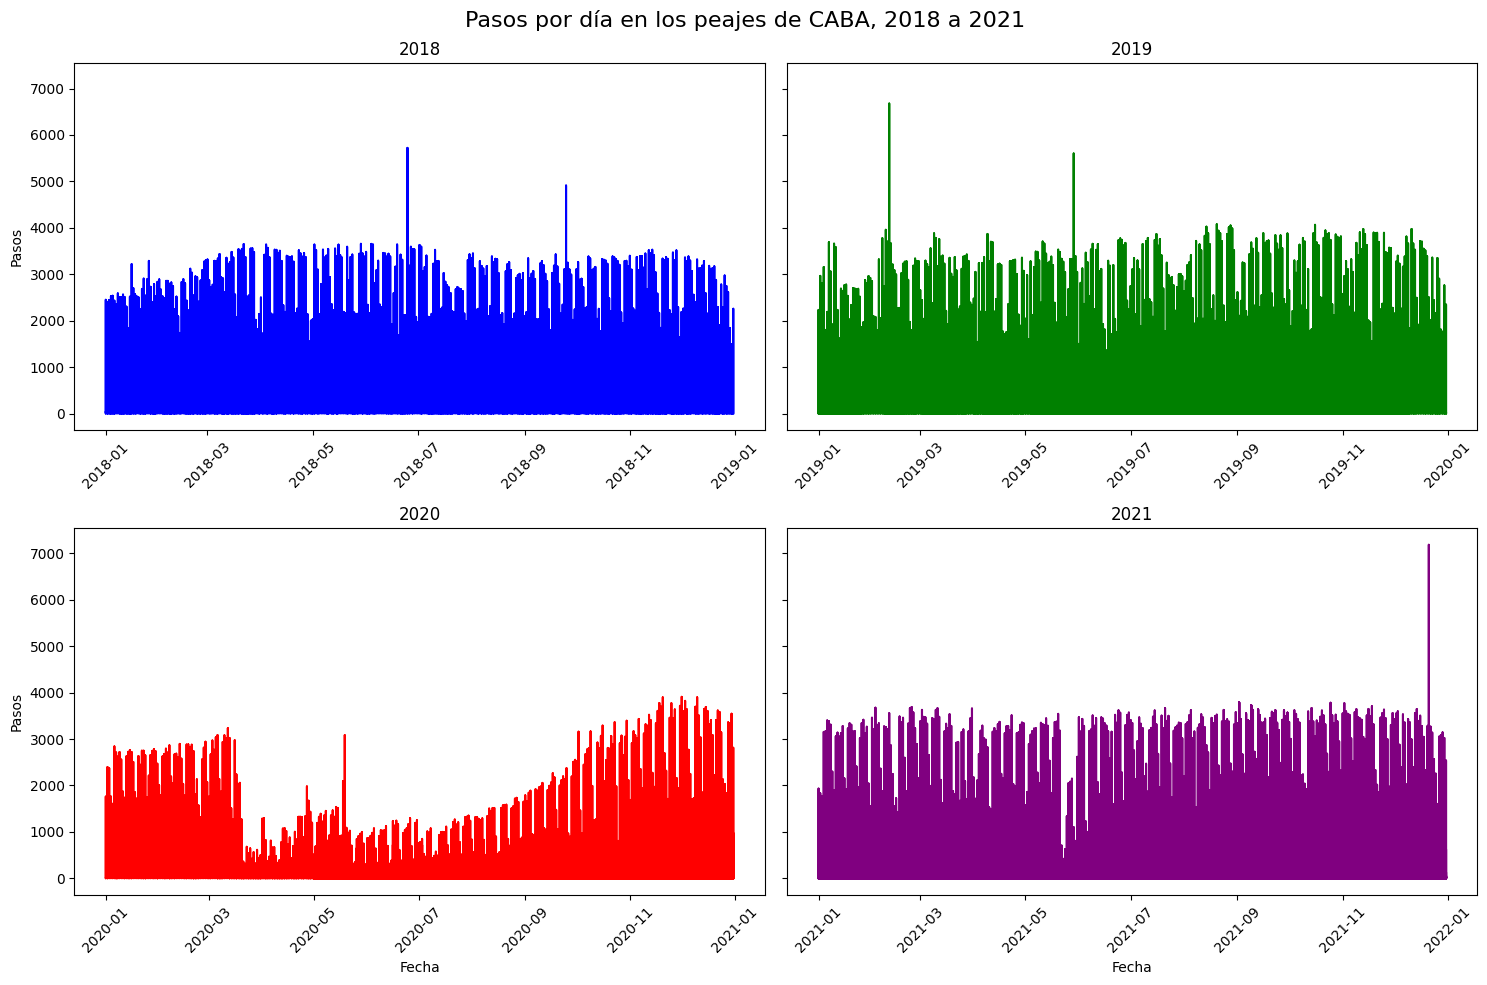

In [31]:
# Creamos subplots para cada año
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10), sharex=False, sharey=True)
fig.suptitle('Pasos por día en los peajes de CABA, 2018 a 2021', fontsize=16)

# Gráfico de datos del 2018
data_2018 = clean_data_2018.copy()
data_2018['fecha'] = pd.to_datetime(data_2018['fecha'])
axes[0, 0].plot(data_2018['fecha'], data_2018['pasos'], label='2018', color='blue')
axes[0, 0].set_title('2018')
axes[0, 0].set_ylabel('Pasos')
axes[0, 0].tick_params(axis='x', rotation=45)

# Gráfico de datos del 2019
data_2019 = clean_data_2019.copy()
data_2019['fecha'] = pd.to_datetime(data_2019['fecha'])
axes[0, 1].plot(data_2019['fecha'], data_2019['pasos'], label='2019', color='green')
axes[0, 1].set_title('2019')
axes[0, 1].tick_params(axis='x', rotation=45)

# Gráfico de datos del 2020
data_2020 = clean_data_2020.copy()
data_2020['fecha'] = pd.to_datetime(data_2020['fecha'])
axes[1, 0].plot(data_2020['fecha'], data_2020['pasos'], label='2020', color='red')
axes[1, 0].set_title('2020')
axes[1, 0].set_xlabel('Fecha')
axes[1, 0].set_ylabel('Pasos')
axes[1, 0].tick_params(axis='x', rotation=45)

# Gráfico de datos del 2021
data_2021 = clean_data_2021.copy()
data_2021['fecha'] = pd.to_datetime(data_2021['fecha'])
axes[1, 1].plot(data_2021['fecha'], data_2021['pasos'], label='2021', color='purple')
axes[1, 1].set_title('2021')
axes[1, 1].set_xlabel('Fecha')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Las gráficas demuestran de una manera clara que el 2020 (gráfica en rojo) fue un año muy atípico también en materia de pasos por peaje, debido a esa caída o "valle" bastante notable entre abril y noviembre, aproximadamente. Por esto, decidimos descartar estos datos dentro de este trabajo.

## Agrupación 2016 a 2023

In [32]:
# Lista con los DataFrames de cada año
dataframes = [clean_data_2016, clean_data_2017, clean_data_2018, clean_data_2019, clean_data_2021, clean_data_2022, clean_data_2023]
# Concatenamos todos los DataFrames en uno solo
merged_data = pd.concat(dataframes, ignore_index=True)

# Aseguramos el orden correcto de las columnas
column_order = ['fecha', 'dia', 'hora', 'id_peaje', 'sentido', 'tipo_vehiculo', 'tipo_cobro', 'pasos']
merged_data = merged_data[column_order]

# Ordenamos por fecha de manera ascendente
merged_data = merged_data.sort_values(by='fecha')

# Muestra información del dataset unificado
print("### INFO DEL DATASET UNIFICADO ###")
print(merged_data.info())
print()
print("############")
print()
print("### VALORES EN LAS COLUMNAS ###")
for columna in merged_data:
    print(f"\nNombre: {columna}")
    valores_unicos = merged_data[columna].unique()
    if len(valores_unicos) < 300:
        print(f"Valores: {valores_unicos}")
    else:
        print(f"Valores: {valores_unicos[:20]}...")

# Limpiamos la memoria
del clean_data_2016, clean_data_2017, clean_data_2018, clean_data_2019, clean_data_2020, clean_data_2021, clean_data_2022, clean_data_2023, data, data_2016, data_2017, data_2018, data_2019, data_2020, data_2021, data_2022, data_2023, data_2024_split, file_list, headers, ftp, data_2024, cols_to_remove, date, column_order, payment_codification, type_codification, direction_codification, days_conversor, dataframes, valores_unicos

# Forzamos la recolección de basura
gc.collect()

print("Memoria limpiada.")

### INFO DEL DATASET UNIFICADO ###
<class 'pandas.core.frame.DataFrame'>
Index: 9601813 entries, 0 to 9601812
Data columns (total 8 columns):
 #   Column         Dtype  
---  ------         -----  
 0   fecha          object 
 1   dia            object 
 2   hora           float64
 3   id_peaje       object 
 4   sentido        object 
 5   tipo_vehiculo  object 
 6   tipo_cobro     object 
 7   pasos          int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 659.3+ MB
None

############

### VALORES EN LAS COLUMNAS ###

Nombre: fecha
Valores: ['2016-01-01' '2016-01-02' '2016-01-03' '2016-01-04' '2016-01-05'
 '2016-01-06' '2016-01-07' '2016-01-08' '2016-01-09' '2016-01-10'
 '2016-01-11' '2016-01-12' '2016-01-13' '2016-01-14' '2016-01-15'
 '2016-01-16' '2016-01-17' '2016-01-18' '2016-01-19' '2016-01-20']...

Nombre: dia
Valores: ['Viernes' 'Sabado' 'Domingo' 'Lunes' 'Martes' 'Miercoles' 'Jueves']

Nombre: hora
Valores: [ 0. 14. 13. 12. 16. 15.  9.  8.  7. 11. 10. 23. 22. 21.



---

# Análisis del dataset resultante

## Identificación de datos faltantes y nulos.


Cantidad de valores NaN por columna:
fecha                 0
dia                   0
hora                  8
id_peaje              0
sentido               0
tipo_vehiculo    391149
tipo_cobro         7454
pasos                 0
dtype: int64

Cantidad de valores nulos por columna:
fecha                 0
dia                   0
hora                  8
id_peaje              0
sentido               0
tipo_vehiculo    391149
tipo_cobro         7454
pasos                 0
dtype: int64


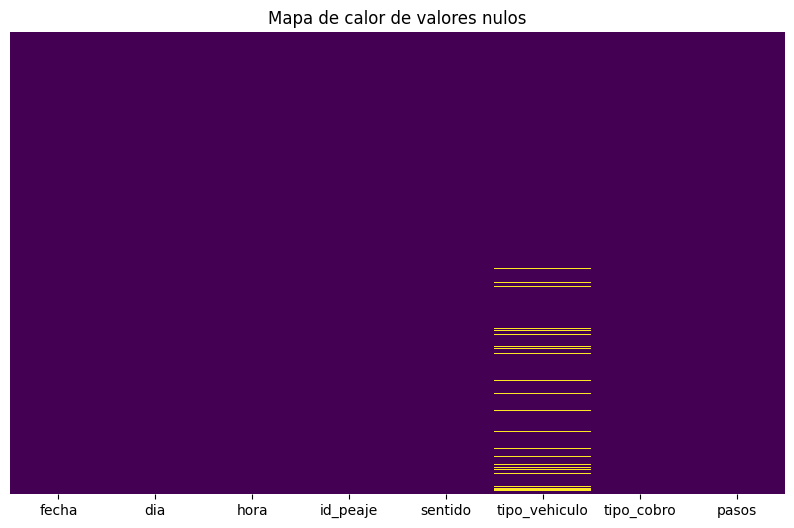

In [33]:
amount_nan_per_column = merged_data.isna().sum()
amount_null_per_column = merged_data.isnull().sum()
print("\nCantidad de valores NaN por columna:")
print(amount_nan_per_column)
print("\nCantidad de valores nulos por columna:")
print(amount_null_per_column)

# Visualización de valores nulos
plt.figure(figsize=(10, 6))
sns.heatmap(merged_data.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.title('Mapa de calor de valores nulos')
plt.show()

### Nulos en la columna hora
Se puede observar que se cuenta con 8 valores nulos, en la columna "hora". A continuación, se muestra la fila completa que los contiene.

In [34]:
null_hour_rows = merged_data[merged_data['hora'].isnull()]
print("Filas con hora nula:")
print(null_hour_rows)
print("Cantidad de filas con hora nula:", len(null_hour_rows))

Filas con hora nula:
              fecha      dia  hora id_peaje    sentido tipo_vehiculo  \
9022672  2023-07-07  Viernes   NaN      ALB  Provincia          None   
9022674  2023-07-07  Viernes   NaN      AVE  Provincia          None   
9022675  2023-07-07  Viernes   NaN      AVE     Centro          None   
9022676  2023-07-07  Viernes   NaN      ILL  Provincia          None   
9022677  2023-07-07  Viernes   NaN      ILL     Centro          None   
9022678  2023-07-07  Viernes   NaN      SAL  Provincia          None   
9022679  2023-07-07  Viernes   NaN      SAR  Provincia          None   
9022673  2023-07-07  Viernes   NaN      ALB     Centro          None   

         tipo_cobro  pasos  
9022672  Infraccion     38  
9022674  Infraccion    133  
9022675  Infraccion    153  
9022676  Infraccion     66  
9022677  Infraccion     71  
9022678  Infraccion      5  
9022679  Infraccion      7  
9022673  Infraccion     34  
Cantidad de filas con hora nula: 8


Todas ellas son del dia 7 de julio del 2023. Ese día se realizó paro de transportes en la ciudad de Buenos Aires en el que todos los peajes fueron gratuitos. Al ser valores tomados de un día atipico se deciden eliminar las filas correspondientes.

In [35]:
rows_to_delete = merged_data[merged_data['hora'].isnull()].index

# Eliminamos las filas
merged_data = merged_data.drop(rows_to_delete)
merged_data = merged_data.reset_index(drop=True)

# Verificamos que las filas se hayan eliminado
print("Filas con hora nula después de la eliminación:")
print(merged_data.isnull().sum())

Filas con hora nula después de la eliminación:
fecha                 0
dia                   0
hora                  0
id_peaje              0
sentido               0
tipo_vehiculo    391141
tipo_cobro         7454
pasos                 0
dtype: int64


Se analizan la cantidad de filas con tipo_vehiculo nulos

In [36]:
null_vehicle_type_rows = merged_data[merged_data['tipo_vehiculo'].isnull()]
print("Filas con tipo_vehiculo nulo:")
print(null_vehicle_type_rows)
print("Cantidad de filas con tipo_vehiculo nulo:", len(null_vehicle_type_rows))

Filas con tipo_vehiculo nulo:
              fecha      dia  hora id_peaje    sentido tipo_vehiculo  \
4369417  2021-01-01  Viernes  23.0      DEC     Centro          None   
4369418  2021-01-01  Viernes  23.0      DEC     Centro          None   
4369419  2021-01-01  Viernes  23.0      AVE  Provincia          None   
4369420  2021-01-01  Viernes  23.0      AVE  Provincia          None   
4369421  2021-01-01  Viernes  23.0      AVE     Centro          None   
...             ...      ...   ...      ...        ...           ...   
9601673  2023-12-31  Domingo   9.0      DEC     Centro          None   
9601678  2023-12-31  Domingo   9.0      ALB     Centro          None   
9601679  2023-12-31  Domingo   9.0      ALB  Provincia          None   
9601680  2023-12-31  Domingo   9.0      AVE     Centro          None   
9601681  2023-12-31  Domingo   9.0      AVE  Provincia          None   

         tipo_cobro  pasos  
4369417  Infraccion      1  
4369418  Infraccion     29  
4369419  Infraccio

In [37]:
# Contamos la cantidad de filas nulas que hay por año
null_vehicle_type_rows = null_vehicle_type_rows.copy()
null_vehicle_type_rows['fecha'] = pd.to_datetime(null_vehicle_type_rows['fecha'], errors='coerce')
nulls_per_year = null_vehicle_type_rows.groupby(null_vehicle_type_rows['fecha'].dt.year).size()
print("Cantidad de filas con tipo_vehiculo nulo por año:")
print(nulls_per_year)

Cantidad de filas con tipo_vehiculo nulo por año:
fecha
2021    135656
2022    132152
2023    123333
dtype: int64


In [38]:
rows_to_delete = merged_data[merged_data['tipo_vehiculo'].isnull()].index

# Eliminamos las filas
merged_data = merged_data.drop(rows_to_delete)
merged_data = merged_data.reset_index(drop=True)

# Verificamos que las filas se hayan eliminado
print("Filas con tipo_vehiculo nulo después de la eliminación:")
print(merged_data.isnull().sum())

Filas con tipo_vehiculo nulo después de la eliminación:
fecha               0
dia                 0
hora                0
id_peaje            0
sentido             0
tipo_vehiculo       0
tipo_cobro       7304
pasos               0
dtype: int64


Se analizan las filas en las cuales la columna tipo_cobro es nulo

In [39]:
null_rows_charge_type = merged_data[merged_data['tipo_cobro'].isnull()]
print("Filas con tipo_cobro nulo:")
print(null_rows_charge_type)
print("Cantidad de filas con tipo_cobro nulo:", len(null_rows_charge_type))

Filas con tipo_cobro nulo:
              fecha     dia  hora id_peaje    sentido tipo_vehiculo  \
8153205  2023-03-23  Jueves  12.0      AVE  Provincia        Pesado   
8174298  2023-03-28  Martes   6.0      AVE  Provincia        Pesado   
8191661  2023-04-01  Sabado  13.0      DEC     Centro        Pesado   
8191923  2023-04-01  Sabado  14.0      DEC     Centro        Pesado   
8192171  2023-04-01  Sabado  21.0      DEC     Centro        Pesado   
...             ...     ...   ...      ...        ...           ...   
8780535  2023-08-31  Jueves   9.0      DEC     Centro        Pesado   
8780628  2023-08-31  Jueves   8.0      DEC     Centro        Pesado   
8780655  2023-08-31  Jueves   9.0      DEC     Centro       Liviano   
8780685  2023-08-31  Jueves   9.0      AVE     Centro       Liviano   
8780695  2023-08-31  Jueves   9.0      AVE  Provincia       Liviano   

        tipo_cobro  pasos  
8153205       None      1  
8174298       None      1  
8191661       None      1  
8191923 

In [40]:
# Contamos la cantidad de filas con tipo_cobro nulo por año
null_rows_charge_type = merged_data[merged_data['tipo_cobro'].isnull()].copy()
null_rows_charge_type['fecha'] = pd.to_datetime(null_rows_charge_type['fecha'], errors='coerce')
nulls_per_year = null_rows_charge_type.groupby(null_rows_charge_type['fecha'].dt.year).size()

print("Cantidad de filas con tipo_cobro nulo por año:")
print(nulls_per_year)


Cantidad de filas con tipo_cobro nulo por año:
fecha
2023    7304
dtype: int64


In [41]:
rows_to_delete = merged_data[merged_data['tipo_cobro'].isnull()].index

# Eliminamos las filas
merged_data = merged_data.drop(rows_to_delete)
merged_data = merged_data.reset_index(drop=True)

# Verificamos que las filas se hayan eliminado
print("Filas con tipo_cobro nulo después de la eliminación:")
print(merged_data.isnull().sum())

Filas con tipo_cobro nulo después de la eliminación:
fecha            0
dia              0
hora             0
id_peaje         0
sentido          0
tipo_vehiculo    0
tipo_cobro       0
pasos            0
dtype: int64


En esta instancia, se completó la eliminación de todos los nulos, por lo que se seguirá con el agrupamiento de los datos cuyas todas columnas sean idénticas excepto la columna pasos, las cuales se sumarán.

In [42]:
# Agrupamos las filas
merged_data = merged_data.groupby(
    ['fecha', 'dia', 'hora', 'id_peaje', 'sentido', 'tipo_vehiculo', 'tipo_cobro'],
    as_index=False
)['pasos'].sum()
merged_data = merged_data.sort_values(by='fecha', ascending=True)

Se hace el mismo proceso para los datos del 2024

In [43]:
rows_to_delete = clean_data_2024[clean_data_2024['tipo_cobro'].isnull()].index
clean_data_2024 = clean_data_2024.drop(rows_to_delete)
clean_data_2024 = clean_data_2024.reset_index(drop=True)
rows_to_delete = clean_data_2024[clean_data_2024['hora'].isnull()].index
clean_data_2024 = clean_data_2024.drop(rows_to_delete)
clean_data_2024 = clean_data_2024.reset_index(drop=True)
rows_to_delete = clean_data_2024[clean_data_2024['tipo_vehiculo'].isnull()].index
clean_data_2024 = clean_data_2024.drop(rows_to_delete)
clean_data_2024 = clean_data_2024.reset_index(drop=True)

# Agrupamos las filas
clean_data_2024 = clean_data_2024.groupby(
    ['fecha', 'dia', 'hora', 'id_peaje', 'sentido', 'tipo_vehiculo', 'tipo_cobro'],
    as_index=False
)['pasos'].sum()
clean_data_2024 = clean_data_2024.sort_values(by='fecha', ascending=True)

________________________________________________________________________________________________________________
## Detección de valores atípicos
Elegimos un valor de 5 desviaciones estándar para la detección de outliers para incluir a aquellos valores que, si bien se alejan de la media considerablemente, pueden llegar a determinar eventos comunes que nos interesan para nuestro análisis de comportamiento del tráfico (feriados, vacaciones, etc.).

Columna: hora
Cantidad de outliers: 0

Columna: pasos
Cantidad de outliers: 27827

Media: 225.97774851721206
Desviación estándar: 831.5251872934998
Outliers: [ 4537  4475  5722 ... 11999  4980  5730]
Outliers superiores:  {27827}
Outliers inferiores:  {0}



c:\Users\Guadalupe\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


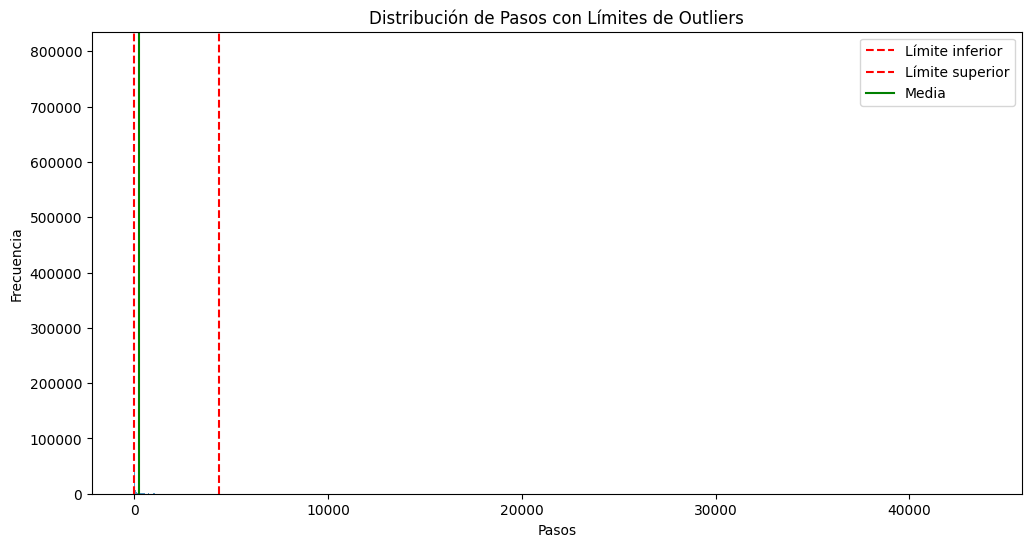

In [44]:
# Filtra las columnas numéricas excluyendo las columnas con tipo de datos "object"
numeric_columns = merged_data.select_dtypes(include=[np.number]).columns

# Crea una lista para almacenar los resultados
outliers_list = []
outliers_upper = 0
outliers_lower = 0

# Itera sobre las columnas y calcula la cantidad de outliers
for column in numeric_columns:
    if column == 'hora':
        outliers = merged_data[column][(merged_data[column] < 0) | (merged_data[column] > 23)]
        mean = None
        std = None
    else:
        mean = merged_data[column].mean()
        std = merged_data[column].std()
        outliers_upper = merged_data[column][merged_data[column] > mean + 5 * std]
        outliers_lower = merged_data[column][merged_data[column] < - 0.01]
        outliers = pd.concat([outliers_upper, outliers_lower])

    # Almacena los resultados en la lista
    outliers = pd.Series(outliers) if not isinstance(outliers, pd.Series) else outliers
    outliers_upper = pd.Series(outliers_upper) if not isinstance(outliers_upper, pd.Series) else outliers_upper
    outliers_lower = pd.Series(outliers_lower) if not isinstance(outliers_lower, pd.Series) else outliers_lower

    outliers_list.append({
        'Columna': column, 
        'Media': mean, 
        'Desviacion Estandar': std, 
        'Cantidad Outliers': len(outliers),
        'Outliers': outliers.values,
        'Outliers superiores': len(outliers_upper),
        'Outliers inferiores': len(outliers_lower)
    })

# Crea un DataFrame a partir de la lista
outliers_info = pd.DataFrame(outliers_list)

# Imprime la información de outliers por columna
for _, row in outliers_info.iterrows():
    print(f"Columna: {row['Columna']}")
    print(f"Cantidad de outliers: {row['Cantidad Outliers']}")
    print()

    if row['Columna'] != 'hora':
        print(f"Media: {row['Media']}")
        print(f"Desviación estándar: {row['Desviacion Estandar']}")
        print(f"Outliers: {row['Outliers']}")
        print(f"Outliers superiores: ", {row['Outliers superiores']})
        print(f"Outliers inferiores: ", {row['Outliers inferiores']})
        print()

        # Creamos la figura y los ejes
        fig, ax = plt.subplots(figsize=(12, 6))

        # Graficamos la distribución de los datos
        sns.histplot(merged_data['pasos'], kde=False, ax=ax)

        # Calculamos los límites de los outliers para la columna actual
        mean = row['Media']
        std = row['Desviacion Estandar']
        outliers_lower = 0.1
        outliers_upper = mean + 5 * std

        # Añadimos líneas verticales para los límites de los outliers
        ax.axvline(outliers_lower, color='r', linestyle='--', label='Límite inferior')
        ax.axvline(outliers_upper, color='r', linestyle='--', label='Límite superior')

        # Añadimos una línea vertical para la media
        ax.axvline(row['Media'], color='g', linestyle='-', label='Media')

        # Configuramos el título y las etiquetas
        ax.set_title('Distribución de Pasos con Límites de Outliers')
        ax.set_xlabel('Pasos')
        ax.set_ylabel('Frecuencia')

        ax.legend()
        plt.show()

El gráfico muestra en perspectiva el conjunto de datos que tomaremos. Si bien no puede apreciarse con claridad la distribución de los datos que nos interesan, podemos ver que el rango completo de la distribución se extiende de manera muy lejana a la media y a los criterios de outliers.

A continuación, se eliminan los outliers de los pasos.

In [45]:
# Calculamos la media y la desviación estándar de la columna 'pasos'
media_pasos = merged_data['pasos'].mean()
std_pasos = merged_data['pasos'].std()

# Mostramos los outliers inferiores
outliers_inferiores = merged_data[merged_data['pasos'] < outliers_lower]
print(f"Cantidad de outliers inferiores: {len(outliers_inferiores)}")
print("Outliers inferiores:")
print(outliers_inferiores)

# Mostramos los outliers superiores
outliers_superiores = merged_data[merged_data['pasos'] > outliers_upper]
print(f"\nCantidad de outliers superiores: {len(outliers_superiores)}")
print("Outliers superiores:")
print(outliers_superiores)

# Guardamos el número de filas antes de eliminar outliers
filas_antes = len(merged_data)

# Eliminamos los outliers
merged_data = merged_data[(merged_data['pasos'] >= outliers_lower) & (merged_data['pasos'] <= outliers_upper)]

# Eliminamos los outliers
clean_data_2024 = clean_data_2024[(clean_data_2024['pasos'] >= outliers_lower) & (clean_data_2024['pasos'] <= outliers_upper)]

# Calculamos el número de filas después de eliminar outliers
filas_despues = len(merged_data)

print(f"Número de filas antes de eliminar outliers: {filas_antes}")
print(f"Número de filas después de eliminar outliers: {filas_despues}")
print(f"Se eliminaron {filas_antes - filas_despues} filas")

# Mostramos un resumen estadístico actualizado
print("\nEstadísticas descriptivas actualizadas:")
print(merged_data.describe())
print(merged_data.info())

# Guardamos el DataFrame limpio en un archivo CSV en el directorio actual
ruta_archivo = 'clean_data.csv'
merged_data.to_csv(ruta_archivo, index=False)
print(f"El archivo se ha guardado como '{ruta_archivo}' en el directorio actual.")

ruta_archivo = 'clean_data_2024.csv'
clean_data_2024.to_csv(ruta_archivo, index=False)
print(f"El archivo se ha guardado como '{ruta_archivo}' en el directorio actual.")


Cantidad de outliers inferiores: 0
Outliers inferiores:
Empty DataFrame
Columns: [fecha, dia, hora, id_peaje, sentido, tipo_vehiculo, tipo_cobro, pasos]
Index: []

Cantidad de outliers superiores: 27827
Outliers superiores:
              fecha      dia  hora id_peaje    sentido tipo_vehiculo  \
642380   2016-12-13   Martes  16.0      AVE  Provincia       Liviano   
648253   2016-12-16  Viernes  18.0      AVE  Provincia       Liviano   
1654117  2018-06-25    Lunes  17.0      AVE  Provincia       Liviano   
1654109  2018-06-25    Lunes  16.0      AVE  Provincia       Liviano   
1654125  2018-06-25    Lunes  18.0      AVE  Provincia       Liviano   
...             ...      ...   ...      ...        ...           ...   
3849963  2022-09-30  Viernes   9.0      AVE  Provincia       Liviano   
3849958  2022-09-30  Viernes   9.0      AVE     Centro        Pesado   
3849951  2022-09-30  Viernes   9.0      AVE     Centro       Liviano   
3849943  2022-09-30  Viernes   9.0      ALB  Provincia  

## Análisis de correlaciones

<Figure size 1200x1000 with 0 Axes>

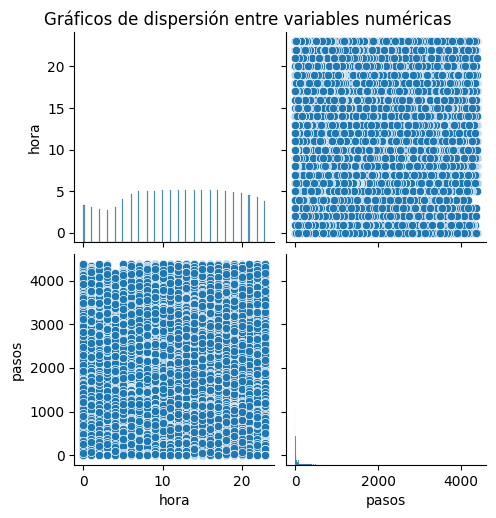

In [46]:
# Se carga el dataset para poder ejecutar esta sección independiente al resto
merged_data = pd.read_csv('clean_data.csv')

numeric_columns = merged_data.select_dtypes(include=[np.number]).columns

# Gráfico de correlaciones
plt.figure(figsize=(12, 10))
sns.pairplot(merged_data[numeric_columns])
plt.suptitle('Gráficos de dispersión entre variables numéricas', y=1.02)
plt.show()

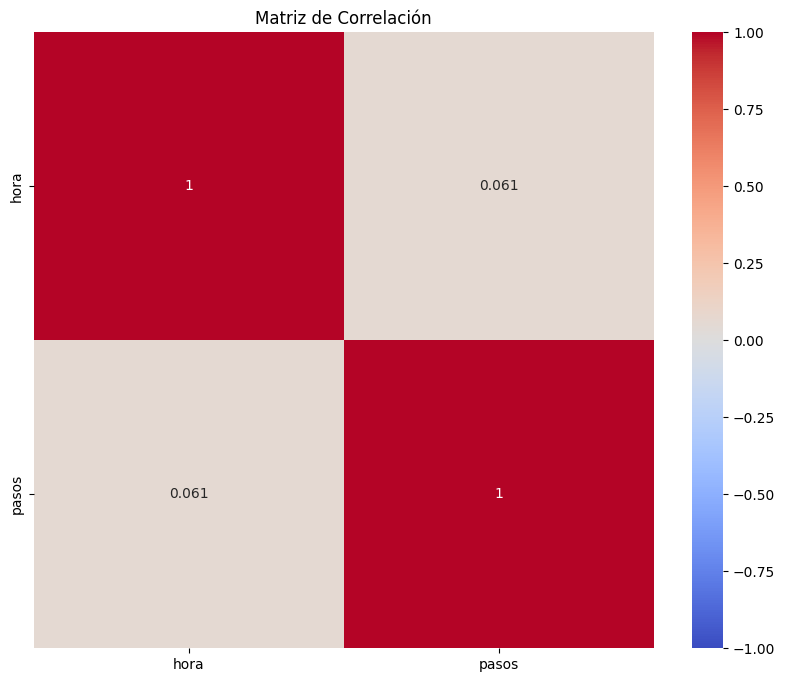

In [47]:
# Seleccionar solo columnas numéricas
numeric_columns = merged_data.select_dtypes(include=[np.number])

# Calcular la matriz de correlación
corr_matrix = numeric_columns.corr()

# Crear un mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Matriz de Correlación')
plt.show()

A simple vista, se puede observar que la columna "pasos" tiene una correlación positiva con la columna "hora", aunque bastante débil. Esto significa que, en promedio, a medida que aumenta la hora, también lo hace en cierta medida el número de pasos. El valor bajo o la falta de una correlatividad más fuerte probablemente se deba a que la relación entre hora y pasos no es lineal, sino más bien cíclica.

### Análisis de valores atípicos

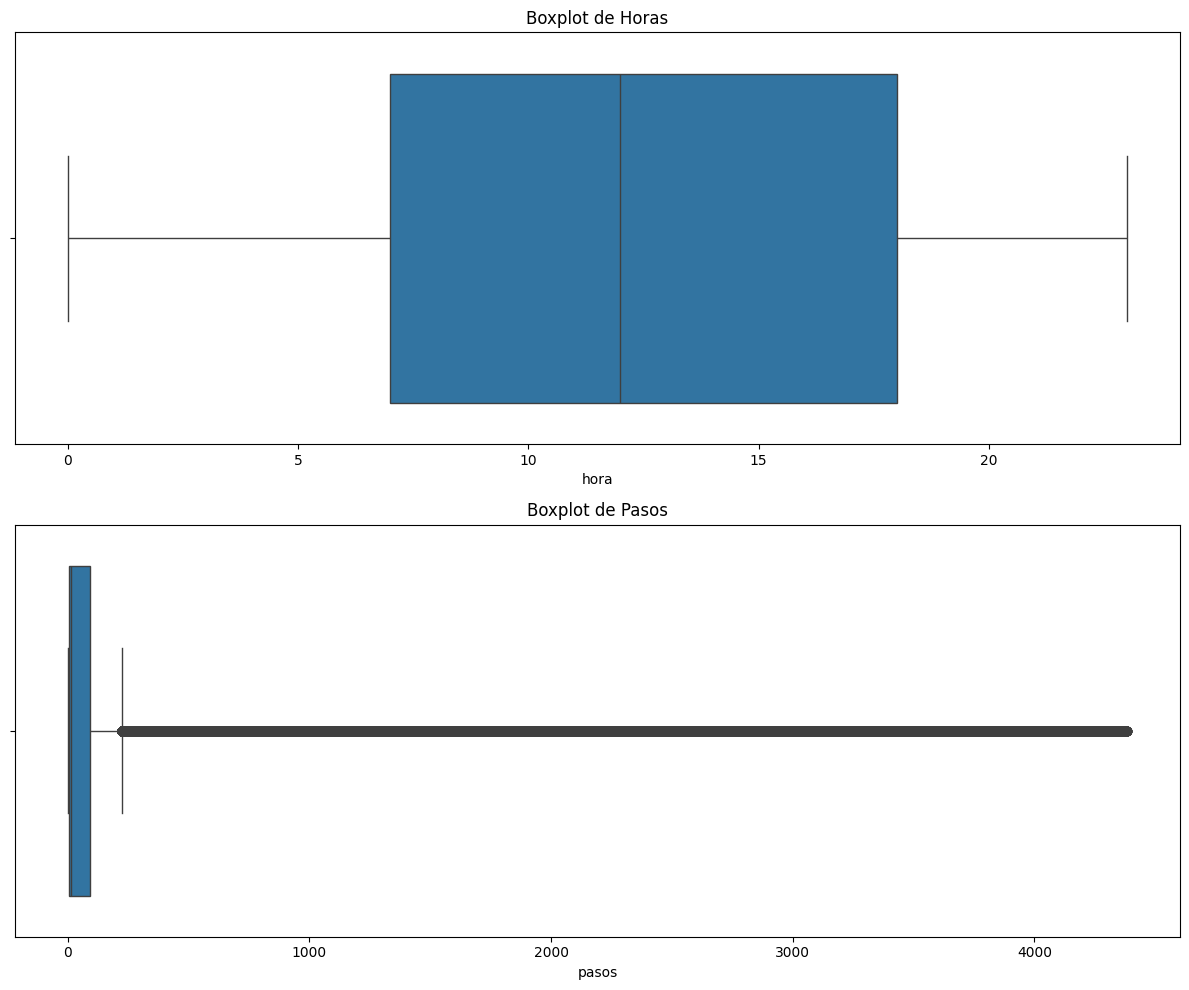

In [48]:
warnings.filterwarnings("ignore", category=FutureWarning)
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

sns.boxplot(data=merged_data, x='hora', ax=axes[0])
axes[0].set_title('Boxplot de Horas')

sns.boxplot(data=merged_data, x='pasos', ax=axes[1])
axes[1].set_title('Boxplot de Pasos')

plt.tight_layout()
plt.show()

Estos Boxplot nos muestran una visión rápida de la mediana y la dispersión de los datos. Por fuera de los bigotes se encuentran algunos valores muy lejanos al rango típico, pero que se mantienen por su utilidad en el análisis de comportamiento del tráfico.

## Análisis de variables categóricas
En esta sección se analizarán las distribuciones de los valores de las variables categóricas, para identificar tendencias y proporciones generales en los datos.


Distribución de pasos totales por dia:
dia
Viernes      15.957799
Jueves       15.684995
Miercoles    15.285244
Martes       14.957350
Lunes        14.343496
Sabado       12.916129
Domingo      10.854988
Name: pasos, dtype: float64


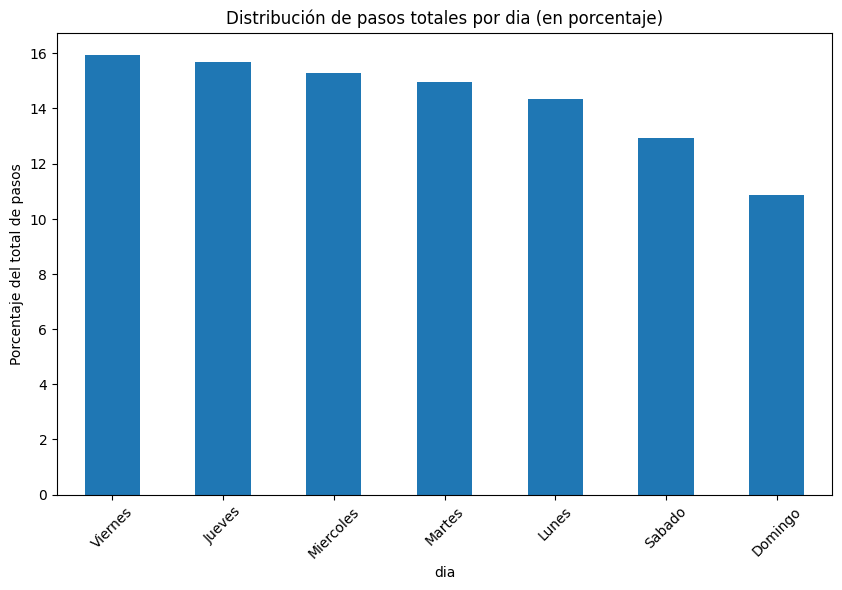


Distribución de pasos totales por id_peaje:
id_peaje
AVE    42.942930
ILL    27.490941
DEC    17.334910
ALB     6.654678
SAR     2.173061
SAL     1.882476
RET     1.521004
Name: pasos, dtype: float64


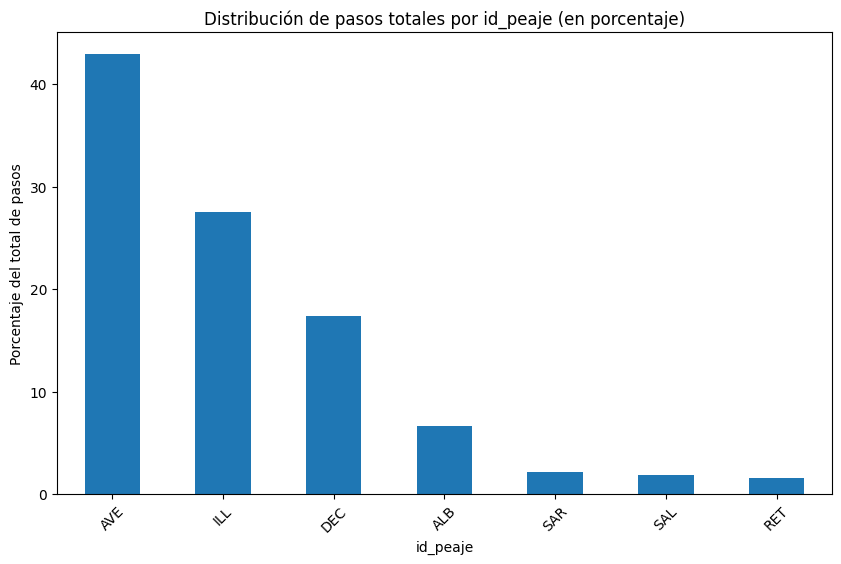


Distribución de pasos totales por sentido:
sentido
Centro       53.99175
Provincia    46.00825
Name: pasos, dtype: float64


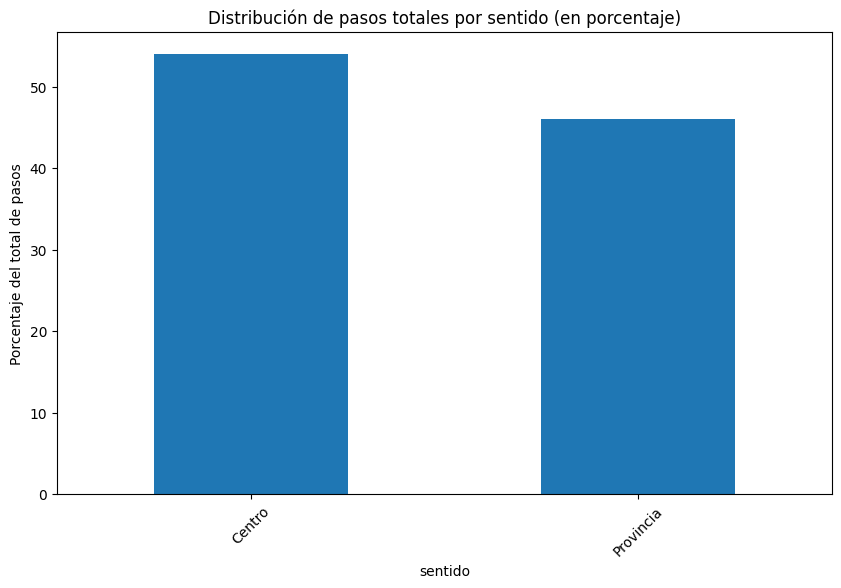


Distribución de pasos totales por tipo_vehiculo:
tipo_vehiculo
Liviano    89.418987
Pesado     10.581013
Name: pasos, dtype: float64


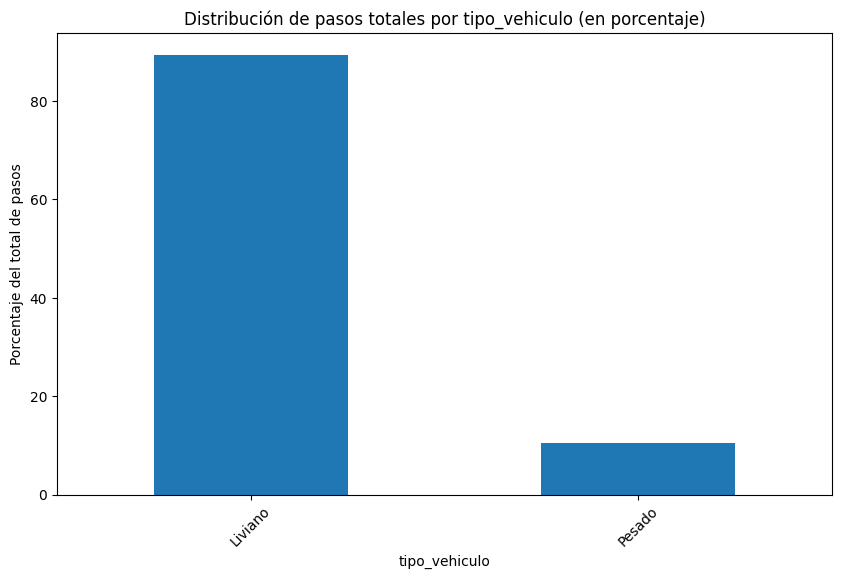


Distribución de pasos totales por tipo_cobro:
tipo_cobro
Tag                  48.245184
Efectivo             37.004366
Monedero virtual      8.022675
Rec.Deuda             4.085866
Exento                1.314476
Tarjeta Magnetica     0.669673
Infraccion            0.656267
Otro                  0.001493
Name: pasos, dtype: float64


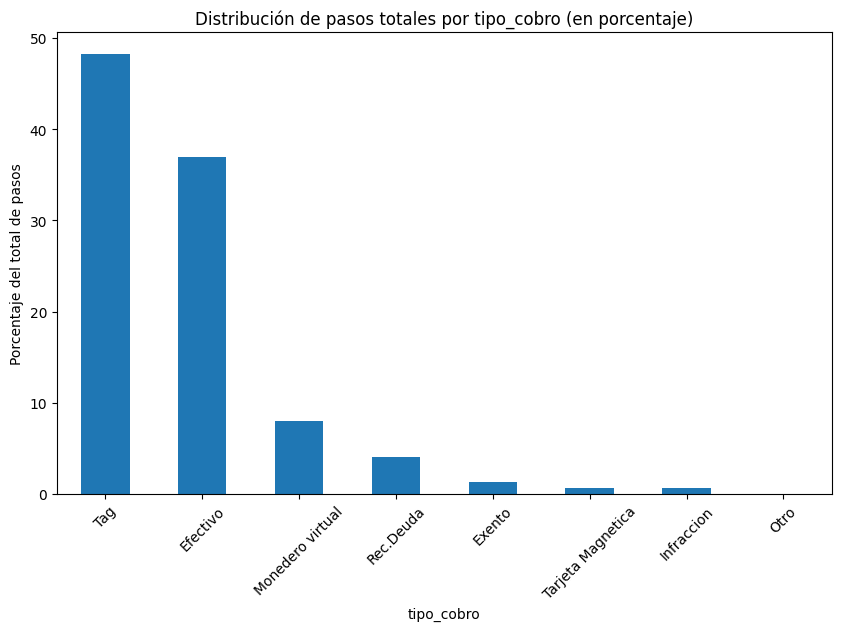

In [49]:
# Distribución de pasos totales en porcentaje:
for columna in ['dia', 'id_peaje', 'sentido', 'tipo_vehiculo', 'tipo_cobro']:
    print(f"\nDistribución de pasos totales por {columna}:")
    pasos_totales = merged_data.groupby(columna)['pasos'].sum().sort_values(ascending=False)
    pasos_totales_percentage = pasos_totales / pasos_totales.sum() * 100
    print(pasos_totales_percentage)
    
    plt.figure(figsize=(10, 6))
    pasos_totales_percentage.plot(kind='bar')
    plt.title(f'Distribución de pasos totales por {columna} (en porcentaje)')
    plt.ylabel('Porcentaje del total de pasos')
    plt.xticks(rotation=45)
    plt.show()

<Figure size 1200x600 with 0 Axes>

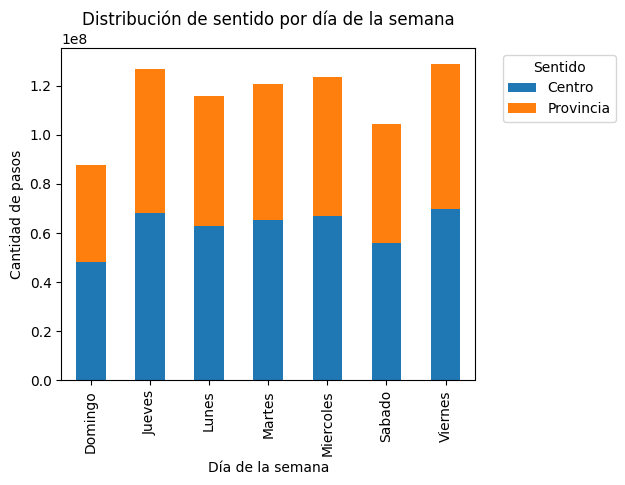

In [50]:
# Gráficos de barras apiladas para relaciones entre variables categóricas:
plt.figure(figsize=(12, 6))
merged_data.groupby(['dia', 'sentido'])['pasos'].sum().unstack().plot(kind='bar', stacked=True)
plt.title('Distribución de sentido por día de la semana')
plt.xlabel('Día de la semana')
plt.ylabel('Cantidad de pasos')
plt.legend(title='Sentido', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

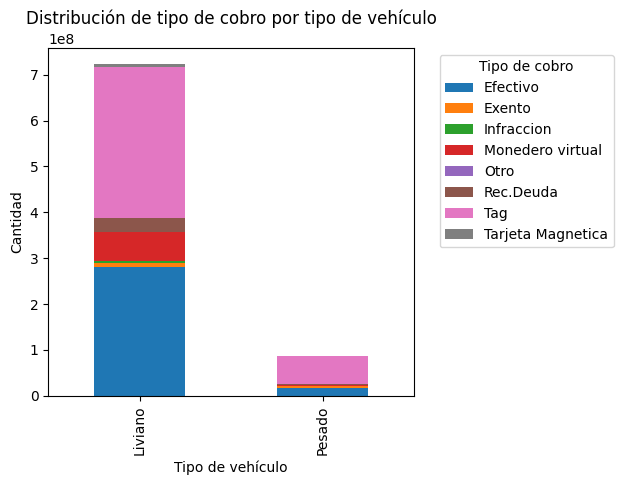

In [51]:
# Heatmap para visualizar la relación entre dos variables categóricas:
plt.figure(figsize=(12, 6))
merged_data.groupby(['tipo_vehiculo', 'tipo_cobro'])['pasos'].sum().unstack().plot(kind='bar', stacked=True)
plt.title('Distribución de tipo de cobro por tipo de vehículo')
plt.xlabel('Tipo de vehículo')
plt.ylabel('Cantidad')
plt.legend(title='Tipo de cobro', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Las distribuciones nos muestran una distribución de datos lógica, que nos permitirá más adelante buscar patrones y otras correlaciones entre las variables para poder construir nuestro modelo de predicción. Algunas relaciones son particularmente interesantes, como por ejemplo la frecuencia con que se utiliza el peaje en función de la hora del día o de la estación del año, o la cantidad de vehículos que se detienen en función del tipo de cobro. Estos análisis adicionales se dejan para la siguiente entrega, en la que utilizaremos un modelo de regresión para predecir comportamientos de tráfico en base a esta información.